# Linear Inferences vs. Inversions: A Conference Presentation
## Benefits of Property-Focused Bayesian Inference

### Overview

This notebook generates publication-quality figures for a conference presentation comparing probabilistic inversions with linear inferences. The presentation demonstrates:

1. **Theoretical foundations** of inversions vs. inferences
2. **Problem setup** with model, data, and forward operator
3. **Probabilistic inversion** and its limitations
4. **Linear inference framework** and its advantages
5. **Exploration of target kernels** and their effects
6. **Practical applications** including gradient inference

---

## Slide 1: Model Space Setup

We begin by establishing our model space $\mathcal{M}$ as an $L^2$ space on interval $[a,b]$ with a smoothness-promoting prior.

### Mathematical Framework

- **Model space**: $\mathcal{M} = L^2([0,1])$ with sine basis
- **Prior covariance**: $C_0 = (-\alpha \Delta)^{-1}$ with Dirichlet boundary conditions
- **Prior mean**: $m_0(x) = $ smooth function promoting expected structure

In [1]:
# Import required packages for presentation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import warnings
import os
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches

# PyGeoInf imports
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import LaplacianInverseOperator, SOLAOperator
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.bayesian import LinearBayesianInference

# Presentation styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

warnings.filterwarnings('ignore', category=UserWarning)

# Create output directory for presentation figures
presentation_dir = 'conference_presentation_figures'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

print("🎯 Conference Presentation: Linear Inferences vs. Inversions")
print("=" * 60)
print("📁 Figures will be saved to:", presentation_dir)

/home/adrian/miniconda3/envs/inferences3/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde


🎯 Conference Presentation: Linear Inferences vs. Inversions
📁 Figures will be saved to: conference_presentation_figures


### The Model Space $\mathcal{M}$

We work in $L^2([0,1])$ with:
- **Basis**: Sine functions for smooth representation
- **Prior covariance**: $C_0 = (-\alpha \Delta)^{-1}$ (inverse scaled Laplacian)
- **Boundary conditions**: Dirichlet (zero at boundaries)
- **Smoothness parameter**: $\alpha$ controls correlation length

This choice promotes smooth solutions while allowing flexibility for data fitting.

In [2]:
# Problem setup parameters
DOMAIN = IntervalDomain(0, 1)
N_BASIS = 20       # High resolution for smooth representations
ALPHA = 0.1         # Smoothness parameter for prior
RANDOM_SEED = 42    # Reproducibility

# Create model space
M = L2Space(N_BASIS, DOMAIN, basis_type='sine')
print(f"📐 Model space: L²([0,1]) with {N_BASIS} sine basis functions")

# Define prior covariance operator: (-α∆)^{-1}
bc_dirichlet = BoundaryConditions(bc_type='dirichlet', left=0, right=0)
C_0 = LaplacianInverseOperator(M, bc_dirichlet, alpha=ALPHA)

# Prior mean function (promoting expected structure)
def prior_mean_function(x):
    """Prior mean promoting smooth, physically reasonable models"""
    return 0.5 * x * (1 - x) + 0.2 * np.sin(2 * np.pi * x)

m_0 = Function(M, evaluate_callable=prior_mean_function)

# Create Gaussian measure on model space
K_KL = 200  # Karhunen-Loève expansion terms
M.create_gaussian_measure(method='kl', kl_expansion=K_KL, covariance=C_0, expectation=m_0)

print(f"✓ Prior covariance: (-{ALPHA}∆)⁻¹ with Dirichlet boundary conditions")
print(f"✓ Prior mean: Smooth function promoting physical structure")
print(f"✓ Karhunen-Loève expansion: {K_KL} terms")

# Get eigenvalue information for analysis
eigenvals = C_0.get_all_eigenvalues(min(50, N_BASIS))
print(f"📊 Eigenvalue decay: {eigenvals[0]:.2e} to {eigenvals[-1]:.2e}")
print(f"📊 Condition number: {eigenvals[0]/eigenvals[-1]:.1e}")

📐 Model space: L²([0,1]) with 20 sine basis functions
DOLFINx found but has compatibility issues, using native solver
LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs
✓ Prior covariance: (-0.1∆)⁻¹ with Dirichlet boundary conditions
✓ Prior mean: Smooth function promoting physical structure
✓ Karhunen-Loève expansion: 200 terms
📊 Eigenvalue decay: 1.01e-01 to 2.53e-04
📊 Condition number: 4.0e+02


### Model Prior Visualization

The prior encodes our beliefs about the model before seeing data. This visualization shows:
- **Prior mean**: Expected model structure
- **Prior samples**: Range of possible models under the prior
- **Uncertainty bands**: Point-wise variability

🎨 Generating prior samples for visualization...
📊 Computing prior uncertainty bounds...


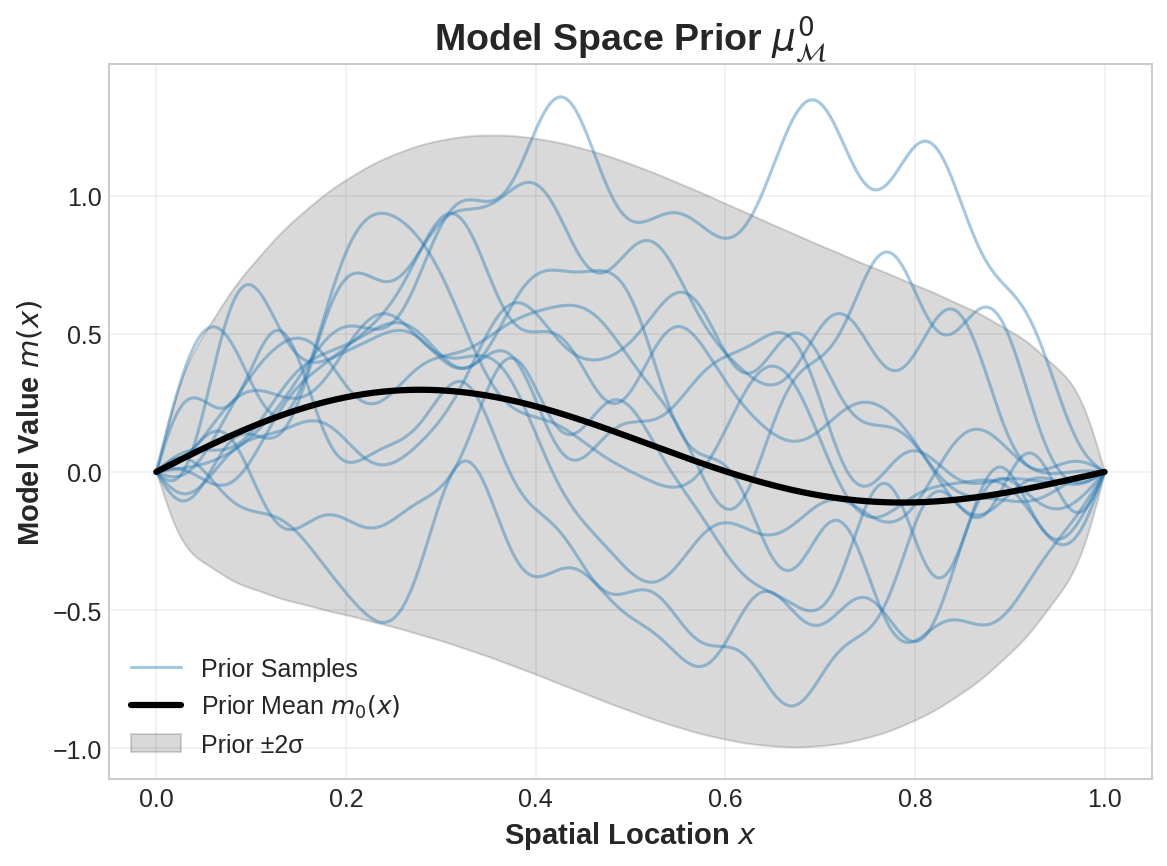

✅ Figure saved: Model space prior samples and mean


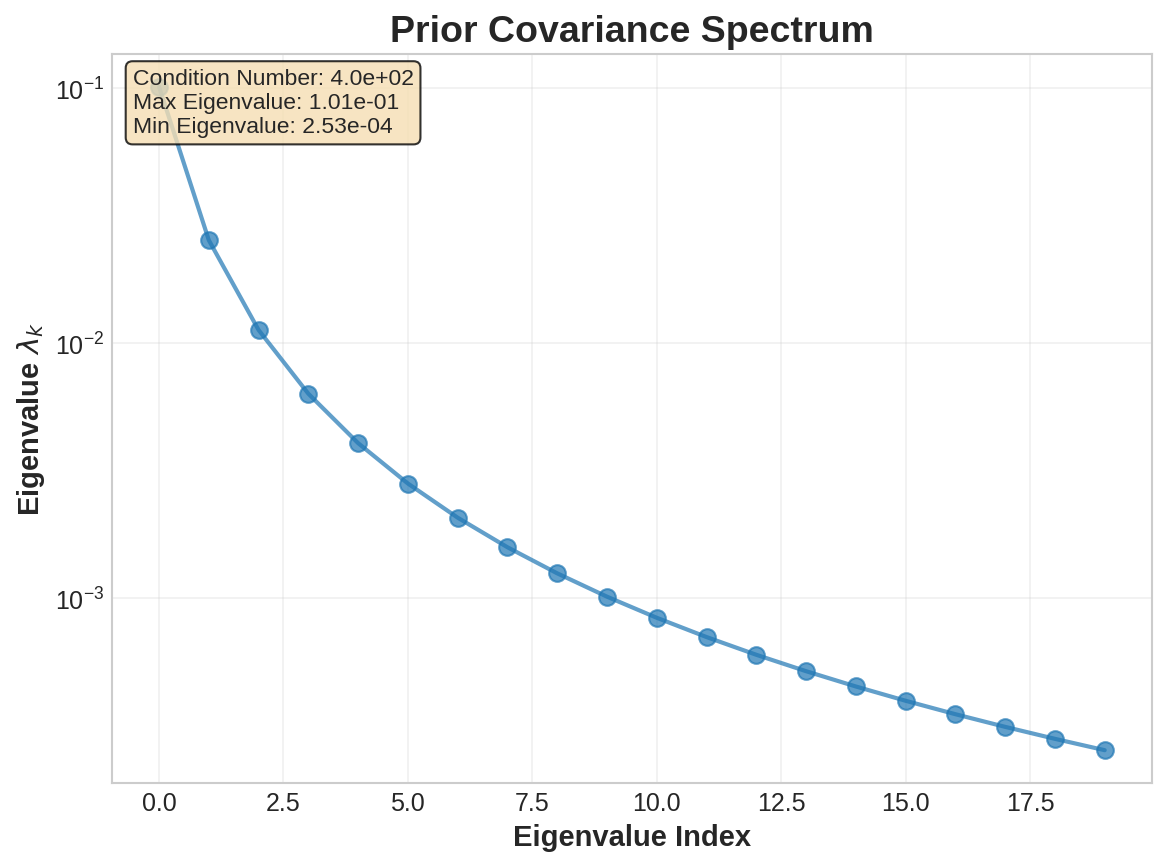

✅ Figure saved: Prior covariance eigenvalue spectrum


In [3]:
x_viz = np.linspace(DOMAIN.a, DOMAIN.b, 1000)
# Left panel: Prior samples and mean (Figure 1)
fig1, ax1 = plt.subplots(figsize=(8, 6))

np.random.seed(RANDOM_SEED)
n_samples = 12
sample_alpha = 0.4

print("🎨 Generating prior samples for visualization...")
for i in range(n_samples):
    sample = M.gaussian_measure.sample()
    ax1.plot(x_viz, sample.evaluate(x_viz), color='tab:blue', alpha=sample_alpha, linewidth=1.5,
             label='Prior Samples' if i == 0 else "")

mean_values = m_0.evaluate(x_viz)
ax1.plot(x_viz, mean_values, 'k-', linewidth=3, label='Prior Mean $m_0(x)$', zorder=10)

print("📊 Computing prior uncertainty bounds...")
std_prior = M.zero
for i, eigenval in enumerate(C_0.spectrum_provider.get_all_eigenvalues()[:100]):
    eigenfunction = C_0.spectrum_provider.get_eigenfunction(i)
    std_prior += eigenval * eigenfunction * eigenfunction
std_values = np.sqrt(std_prior.evaluate(x_viz))

ax1.fill_between(x_viz, mean_values - 2*std_values, mean_values + 2*std_values,
                 alpha=0.15, color='black', label='Prior ±2σ')

ax1.set_xlabel('Spatial Location $x$', fontweight='bold')
ax1.set_ylabel('Model Value $m(x)$', fontweight='bold')
ax1.set_title('Model Space Prior $\\mu_{\\mathcal{M}}^0$', fontweight='bold', fontsize=18)
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(presentation_dir, 'slide1_model_prior_samples.png'))
plt.savefig(os.path.join(presentation_dir, 'slide1_model_prior_samples.pdf'))
plt.show()

print("✅ Figure saved: Model space prior samples and mean")

# Right panel: Eigenvalue spectrum (Figure 2)
fig2, ax2 = plt.subplots(figsize=(8, 6))

ax2.semilogy(eigenvals, 'bo-', markersize=8, linewidth=2, alpha=0.7, color='tab:blue')
ax2.set_xlabel('Eigenvalue Index', fontweight='bold')
ax2.set_ylabel('Eigenvalue $\\lambda_k$', fontweight='bold')
ax2.set_title('Prior Covariance Spectrum', fontweight='bold', fontsize=18)
ax2.grid(True, alpha=0.3)

textstr = f"Condition Number: {eigenvals[0]/eigenvals[-1]:.1e}\n" \
           f"Max Eigenvalue: {eigenvals[0]:.2e}\n" \
           f"Min Eigenvalue: {eigenvals[-1]:.2e}"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(os.path.join(presentation_dir, 'slide1_model_prior_spectrum.png'))
plt.savefig(os.path.join(presentation_dir, 'slide1_model_prior_spectrum.pdf'))
plt.show()

print("✅ Figure saved: Prior covariance eigenvalue spectrum")

## Slide 2: Data Space Setup

### Data Space $\mathcal{D}$ and Observations

We define:
- **Data space**: $\mathcal{D} \cong \mathbb{R}^{N_d}$ (finite-dimensional)
- **Data measure**: $\mu_{\mathcal{D}} = \mathcal{N}(\tilde{\mathbf{d}}, \mathbf{C}_{\mathcal{D}})$
- **Observations**: Noisy measurements $\tilde{\mathbf{d}} = G(\bar{m}) + \bm{\eta}$
- **Noise model**: $\bm{\eta} \sim \mathcal{N}(0, \mathbf{C}_{\mathcal{D}})$

In [4]:
# Data space setup
N_DATA = 60
D = EuclideanSpace(N_DATA)

print(f"📊 Data space: ℝ^{N_DATA}")

# Create true model for synthetic data generation
def true_model_function(x):
    """Complex true model with multiple features"""
    # Gaussian envelope
    envelope = np.exp(-((x - 0.6)/0.3)**2)
    # Oscillatory component
    oscillation = np.sin(4 * np.pi * x)
    # Linear trend
    trend = 0.4 * x
    # Localized feature
    feature = 0.8 * np.exp(-((x - 0.8)/0.08)**2)
    return envelope * oscillation + trend + feature

m_true = Function(M, evaluate_callable=true_model_function)

print("🎯 True model created with multiple challenging features")

📊 Data space: ℝ^60
🎯 True model created with multiple challenging features


### Slide 3: Forward Operator and Sensitivity Kernels

The forward operator $G: \mathcal{M} \to \mathcal{D}$ maps models to data:
$$[G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}$$

where $K_i$ are sensitivity kernels determining measurement sensitivity.

In [5]:
# Create forward operator with normal modes (representing physical measurements)
normal_modes_provider = NormalModesProvider(
    M,
    gaussian_width_percent_range=(8, 15),  # Wider kernels for realistic measurements
    freq_range=(3, 8),                     # Moderate frequency range
    random_state=RANDOM_SEED
)

G = SOLAOperator(M, D, normal_modes_provider, integration_method='trapz', n_points=1000)

print(f"🔄 Forward operator G: ℳ → ℝ^{N_DATA}")
print(f"📡 Sensitivity kernels: Normal modes with Gaussian envelopes")

# Generate synthetic observations
np.random.seed(RANDOM_SEED)
d_clean = G(m_true)
noise_level = 0.05  # 5% noise level
noise_std = noise_level * np.max(np.abs(d_clean))
noise = np.random.normal(0, noise_std, d_clean.shape)
d_tilde = d_clean + noise

# Create data measure
assumed_std = noise_std * 5
noise_variance = assumed_std**2
C_D_matrix = noise_variance * np.eye(N_DATA)
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)
gaussian_D_error = GaussianMeasure.from_covariance_matrix(D, C_D_matrix)

print(f"📈 Signal-to-noise ratio: {np.max(np.abs(d_clean))/noise_std:.1f}")
print(f"🔊 Noise level: {noise_level*100}% of signal amplitude")

🔄 Forward operator G: ℳ → ℝ^60
📡 Sensitivity kernels: Normal modes with Gaussian envelopes
📈 Signal-to-noise ratio: 20.0
🔊 Noise level: 5.0% of signal amplitude


🎬 Generating animation frames for PowerPoint...
   ✓ Frame 1 saved
   ✓ Frame 1 saved
   ✓ Frame 2 saved
   ✓ Frame 2 saved
   ✓ Frame 3 saved
   ✓ Frame 3 saved
   ✓ Frame 4 saved
   ✓ Frame 4 saved
   ✓ Frame 5 saved
📊 Creating final complete figure...
   ✓ Frame 5 saved
📊 Creating final complete figure...


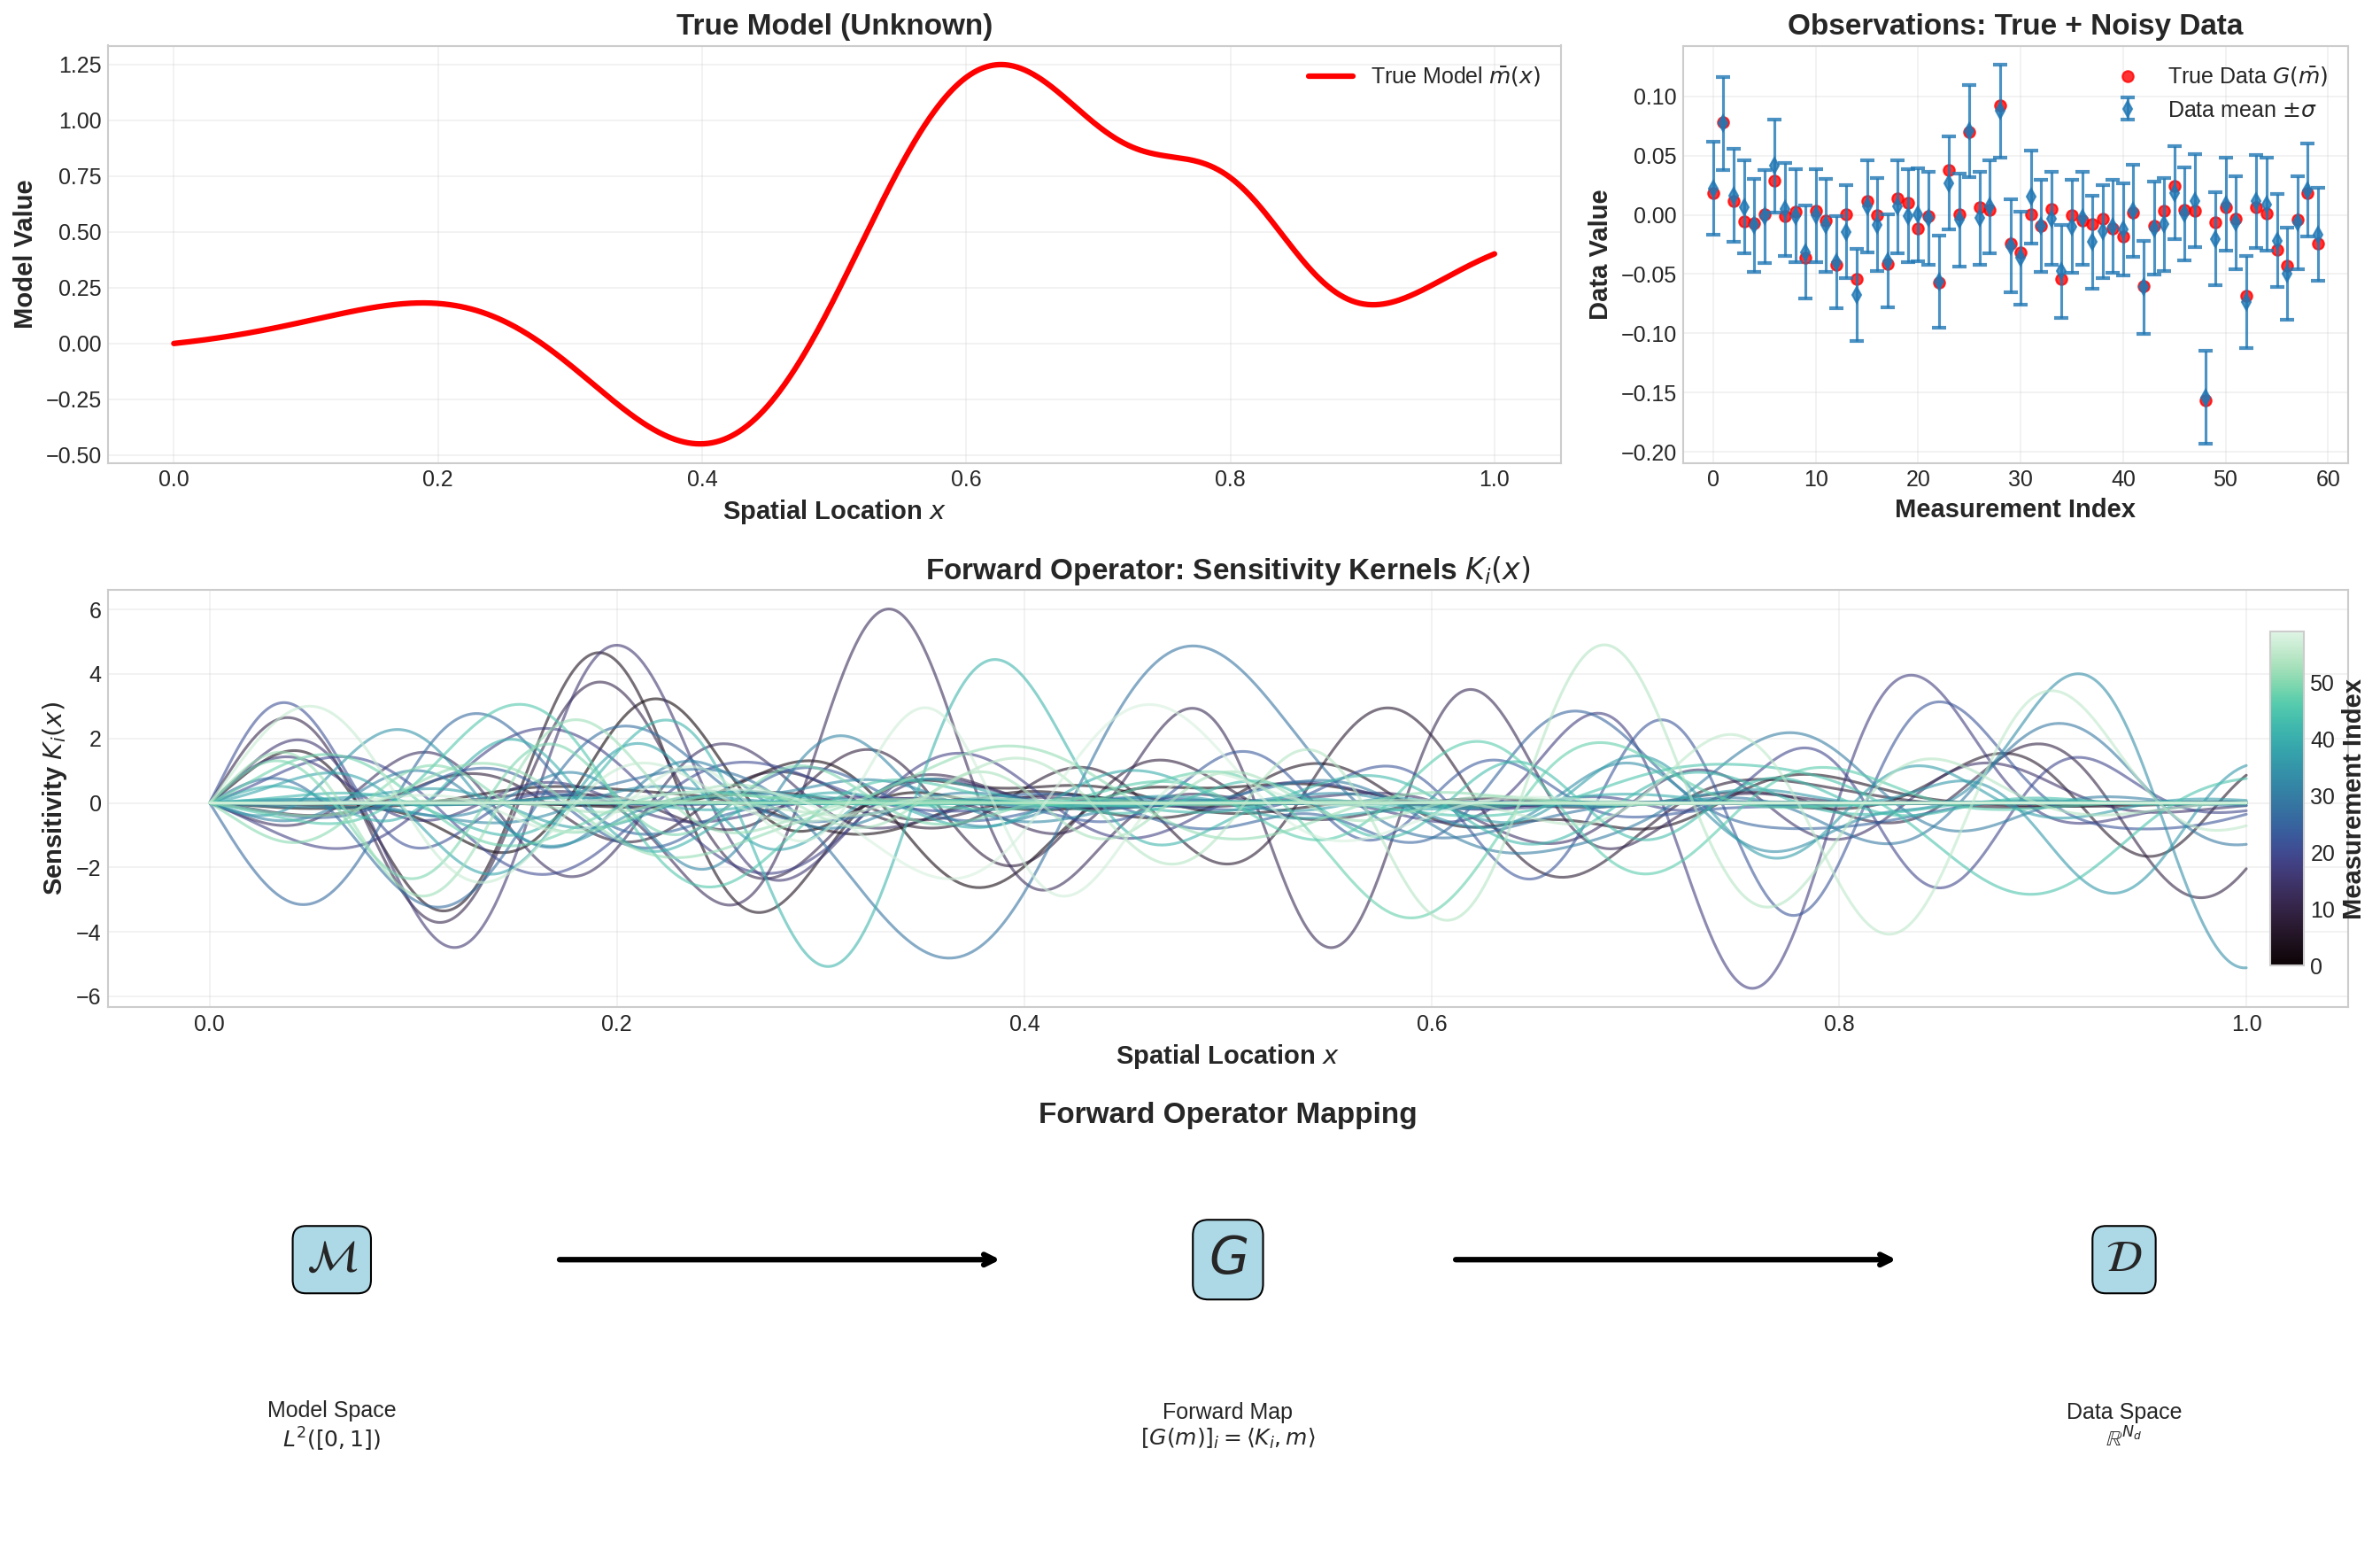

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def create_forward_operator_frame(frame_number, save_prefix="slide2_forward_operator"):
    """
    Create progressive animation frames for PowerPoint presentation.
    All frames have identical size and layout structure for easy alignment.

    Frame 1: True model only
    Frame 2: True model + sensitivity kernels + forward operator schematic
    Frame 3: True model + sensitivity kernels + schematic + true data only
    Frame 4: True model + sensitivity kernels + schematic + true data + noisy measurements
    Frame 5: Complete figure with all elements
    """

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

    # ALWAYS create all subplots for consistent sizing
    ax1 = fig.add_subplot(gs[0, :2])  # Model subplot
    ax2 = fig.add_subplot(gs[0, 2])   # Data subplot
    ax3 = fig.add_subplot(gs[1, :])   # Sensitivity kernels subplot
    ax4 = fig.add_subplot(gs[2, :])   # Forward operator schematic

    # Frame 1+: True model (always present)
    ax1.plot(x_viz, m_true.evaluate(x_viz), 'r-', linewidth=3, label='True Model $\\bar{m}(x)$')
    ax1.set_xlabel('Spatial Location $x$', fontweight='bold')
    ax1.set_ylabel('Model Value', fontweight='bold')
    ax1.set_title('True Model (Unknown)', fontweight='bold', fontsize=16)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Data subplot - configure but may be empty initially
    data_indices = np.arange(N_DATA)
    if frame_number >= 3:
        # Only show axes and labels when we have data to show
        ax2.set_xlabel('Measurement Index', fontweight='bold')
        ax2.set_ylabel('Data Value', fontweight='bold')
        ax2.set_title('Observations', fontweight='bold', fontsize=16)
        ax2.grid(True, alpha=0.3)
    else:
        # Hide everything for early frames
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)

    # Sensitivity kernels subplot
    if frame_number >= 2:
        # Frame 2+: Add sensitivity kernels
        colors = sns.color_palette("mako", N_DATA)
        for i in range(N_DATA):
            kernel_vals = G.function_provider.get_function_by_index(i).evaluate(x_viz)
            ax3.plot(x_viz, kernel_vals, color=colors[i], alpha=0.6, linewidth=1.5)

        ax3.set_xlabel('Spatial Location $x$', fontweight='bold')
        ax3.set_ylabel('Sensitivity $K_i(x)$', fontweight='bold')
        ax3.set_title('Forward Operator: Sensitivity Kernels $K_i(x)$', fontweight='bold', fontsize=16)
        ax3.grid(True, alpha=0.3)

        # Add colorbar
        cax = inset_axes(ax3, width="1.5%", height="80%", loc='center right', borderpad=2)
        sm = plt.cm.ScalarMappable(cmap='mako', norm=plt.Normalize(vmin=0, vmax=N_DATA-1))
        sm.set_array([])
        cbar = plt.colorbar(sm, cax=cax)
        cbar.set_label('Measurement Index', fontweight='bold')
    else:
        # Hide sensitivity kernels subplot for frame 1
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.set_title('')
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.spines['bottom'].set_visible(False)
        ax3.spines['left'].set_visible(False)

    # Forward operator schematic
    if frame_number >= 2:
        ax4.text(0.1, 0.7, '$\\mathcal{M}$', fontsize=24, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        ax4.text(0.5, 0.7, '$G$', fontsize=28, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        ax4.text(0.9, 0.7, '$\\mathcal{D}$', fontsize=24, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        # Arrows
        ax4.annotate('', xy=(0.4, 0.7), xytext=(0.2, 0.7),
                     arrowprops=dict(arrowstyle='->', lw=3, color='black'))
        ax4.annotate('', xy=(0.8, 0.7), xytext=(0.6, 0.7),
                     arrowprops=dict(arrowstyle='->', lw=3, color='black'))

        ax4.text(0.1, 0.3, 'Model Space\n$L^2([0,1])$', fontsize=12, ha='center', va='center')
        ax4.text(0.5, 0.3, 'Forward Map\n$[G(m)]_i = \\langle K_i, m \\rangle$', fontsize=12, ha='center', va='center')
        ax4.text(0.9, 0.3, 'Data Space\n$\\mathbb{R}^{N_d}$', fontsize=12, ha='center', va='center')

        ax4.set_title('Forward Operator Mapping', fontweight='bold', fontsize=16)

    # Always set axis properties for consistent layout
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    if frame_number >= 3:
        # Frame 3+: Add true data only
        ax2.plot(data_indices, d_clean, 'ro', alpha=0.8, markersize=6, label='True Data $G(\\bar{m})$')
        ax2.set_title('Observations: True Data', fontweight='bold', fontsize=16)
        ax2.legend()

    if frame_number == 4:
        # Frame 4+: Add noisy measurements
        ax2.plot(data_indices, d_tilde, 'bd', alpha=0.8,
                label='Noisy Measurements', markersize=6, color='tab:blue')
        ax2.set_title('Observations: True + Noisy Data', fontweight='bold', fontsize=16)
        ax2.legend()

    if frame_number >= 5:
        # Frame 5: Complete with all data types
        ax2.errorbar(data_indices, d_tilde, yerr=assumed_std, fmt='bd', alpha=0.8,
                capsize=4, capthick=2, label='Data mean $\pm \\sigma$', markersize=6, color='tab:blue')
        ax2.set_title('Observations: True + Noisy Data', fontweight='bold', fontsize=16)
        ax2.legend()
        # Could add more elements here if needed

    plt.tight_layout()

    # Save frame
    frame_filename = f'{save_prefix}_frame{frame_number}.png'
    plt.savefig(os.path.join(presentation_dir, frame_filename), dpi=300, bbox_inches='tight')

    return fig
# Generate all animation frames (but don't display them)
print("🎬 Generating animation frames for PowerPoint...")
for frame in range(1, 6):
    fig = create_forward_operator_frame(frame)
    plt.close(fig)  # Close each frame to save memory
    print(f"   ✓ Frame {frame} saved")

# Create and display the final complete figure
print("📊 Creating final complete figure...")
final_fig = create_forward_operator_frame(5, "slide2_forward_operator_complete")

plt.show()

## Slide 3: Probabilistic Inversion - Computing the Posterior

### Bayesian Update

Using Bayes' theorem, we compute the model posterior:

$$\mu_{\mathcal{M}}^{\tilde{\mathbf{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$$

where:
- **Posterior covariance**: $C_{\mathcal{M}} = (G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1})^{-1}$
- **Posterior mean**: $\tilde{m} = C_{\mathcal{M}}(G^* \mathbf{C}_{\mathcal{D}}^{-1} \tilde{\mathbf{d}} + C_0^{-1} m_0)$

This represents our updated beliefs about the model after seeing the data.

In [7]:
# Import missing classes
from pygeoinf.bayesian import LinearBayesianInversion
from pygeoinf.forward_problem import LinearForwardProblem

# Compute Bayesian inversion using PyGeoInf
print("🔄 Computing Bayesian inversion...")

# Create forward problem
forward_problem = LinearForwardProblem(G, gaussian_D_error)

# Create Bayesian inversion object (use LinearBayesianInversion for standard inversion)
bayesian_inversion = LinearBayesianInversion(forward_problem, M.gaussian_measure)

# Compute model posterior
solver = CholeskySolver()
model_posterior = bayesian_inversion.model_posterior_measure(d_tilde, solver)

print(f"✓ Posterior computed successfully")

# Get posterior mean (expectation is already a function)
posterior_mean = model_posterior.expectation

print(f"✓ Bayesian inversion completed")

🔄 Computing Bayesian inversion...
✓ Posterior computed successfully
✓ Bayesian inversion completed
✓ Posterior computed successfully
✓ Bayesian inversion completed


### Inversion Results - Posterior vs. Truth

This slide shows the power and limitations of probabilistic inversion:
- **Success**: Posterior mean recovers true model reasonably well
- **Uncertainty**: Posterior samples show remaining uncertainty
- **Challenge**: How do we extract specific information from this posterior?

🎨 Generating posterior samples for inversion results...


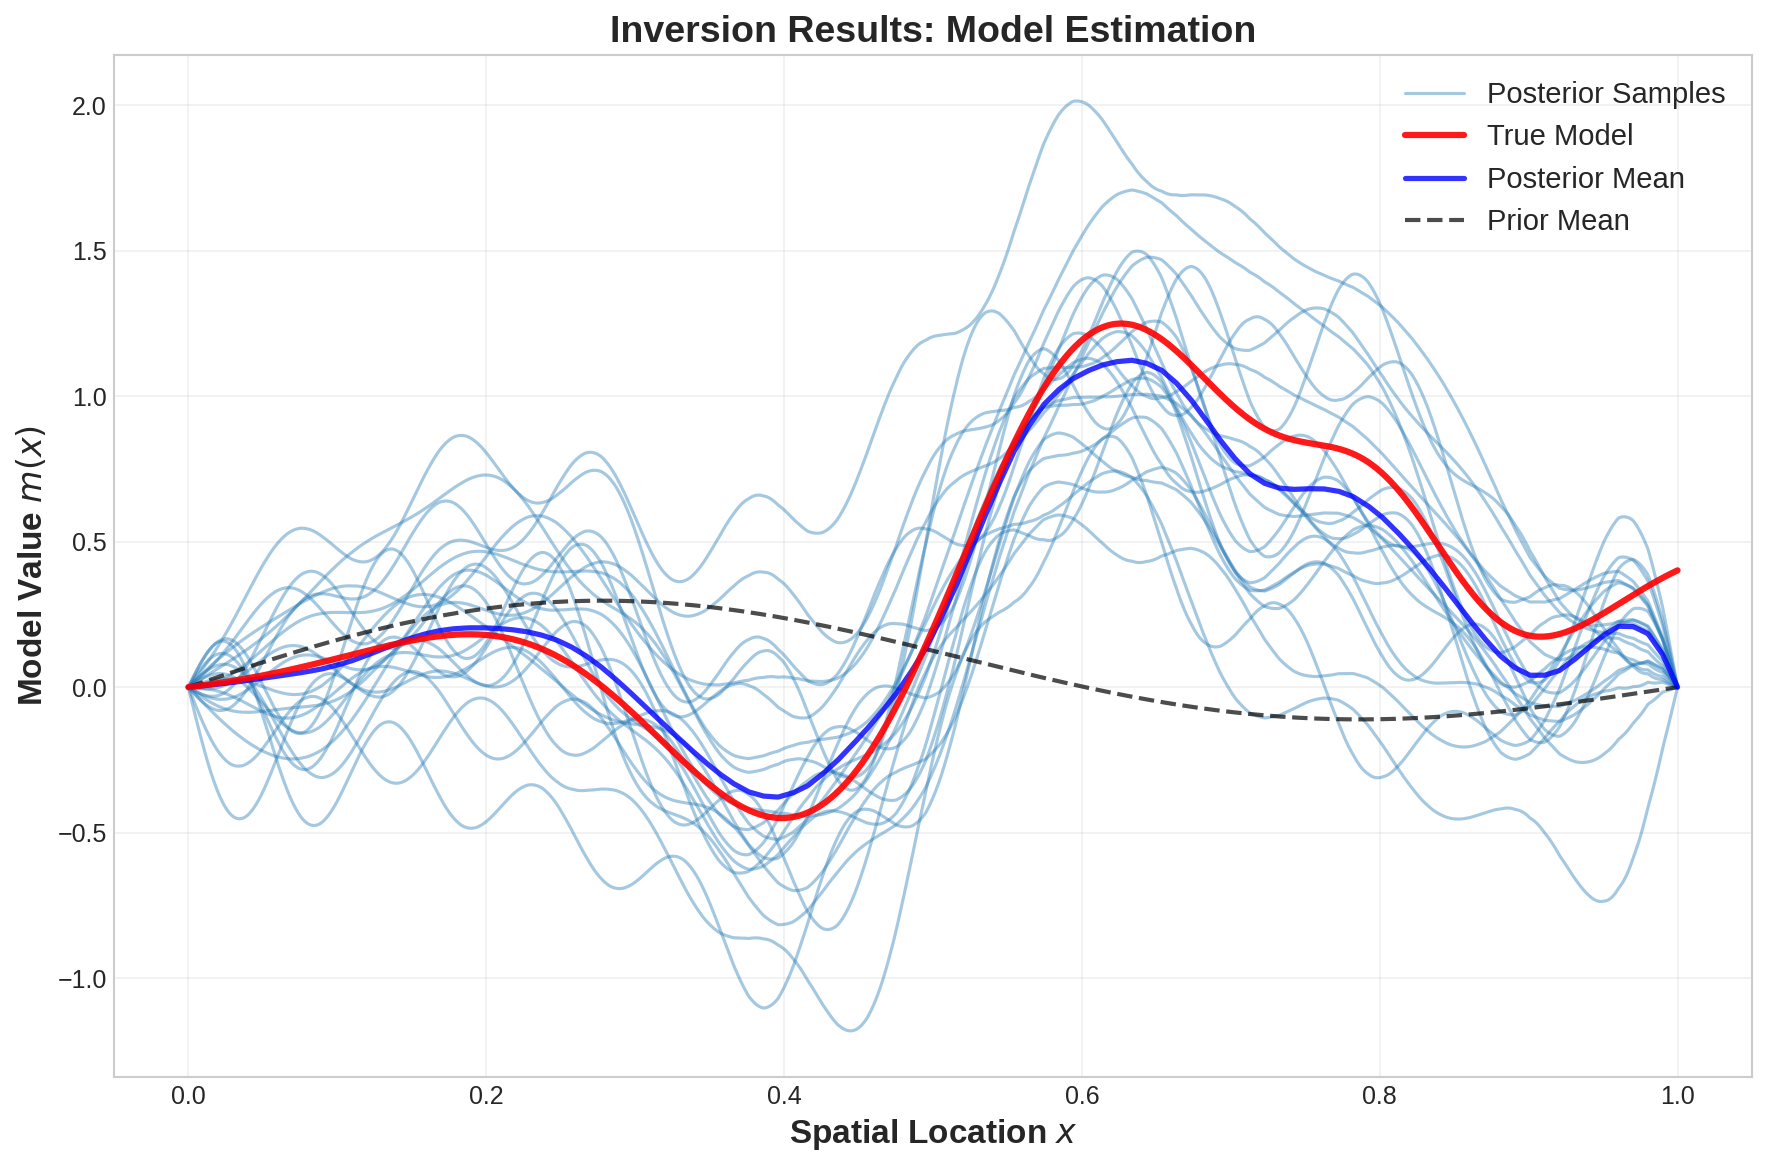

✅ Slide 3 figure saved: Inversion results and analysis


In [8]:
# Create figure for inversion results (Slide 7) - model estimation only
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

# Generate posterior samples for visualization using prior samples + update
print("🎨 Generating posterior samples for inversion results...")
np.random.seed(RANDOM_SEED)
n_post_samples = 20
cov_M_posterior = model_posterior.covariance.matrix(dense=True)  # Use dense matrix for better visualization
# Recreatig posterior gaussian measure with dense covariance for sampling
mu_M  = GaussianMeasure.from_covariance_matrix(M, cov_M_posterior, expectation=model_posterior.expectation)

# Generate samples by perturbing the posterior mean
for i in range(n_post_samples):
    sample_values = mu_M.sample().evaluate(x_viz)
    ax.plot(x_viz, sample_values, color='tab:blue', alpha=sample_alpha, linewidth=1.5,
             label='Posterior Samples' if i == 0 else "")

ax.plot(x_viz, m_true.evaluate(x_viz), 'r-', linewidth=3, label='True Model', alpha=0.9, zorder=10)
ax.plot(x_viz, posterior_mean.evaluate(x_viz), 'b-', linewidth=2.5, label='Posterior Mean', alpha=0.8, zorder=9)
ax.plot(x_viz, m_0.evaluate(x_viz), 'k--', linewidth=2, label='Prior Mean', alpha=0.7, zorder=8)

ax.set_xlabel('Spatial Location $x$', fontweight='bold', fontsize=16)
ax.set_ylabel('Model Value $m(x)$', fontweight='bold', fontsize=16)
ax.set_title('Inversion Results: Model Estimation', fontsize=18, fontweight='bold')
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{presentation_dir}/slide3_inversion_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Slide 3 figure saved: Inversion results and analysis")

## Slide 8: The Challenge - Extracting Information from Posterior

### Key Questions That Motivate Linear Inference

Having computed the model posterior $\mu_{\mathcal{M}}^{\tilde{\mathbf{d}}}$, we face important questions:

1. **What is the average value** of the model over a specific region?
2. **How does the model behave** near a particular location?
3. **What is the total integrated quantity** over the domain?
4. **Can we extract gradients** or other derived quantities?

### The Problem

Even with an analytical posterior solution, extracting specific properties is **not trivial**:
- Direct sampling is computationally expensive
- Point-wise evaluation doesn't give integrated quantities
- Derived quantities (gradients, averages) require careful computation
- Uncertainty propagation becomes complex

**Solution**: Linear inference provides a principled framework for extracting properties with proper uncertainty quantification.

🎬 Generating challenge questions animation frames for PowerPoint...
   ✓ Frame 1 saved
   ✓ Frame 1 saved
   ✓ Frame 2 saved
   ✓ Frame 2 saved
   ✓ Frame 3 saved
   ✓ Frame 3 saved
   ✓ Frame 4 saved
📊 Creating final complete challenge questions figure...
   ✓ Frame 4 saved
📊 Creating final complete challenge questions figure...


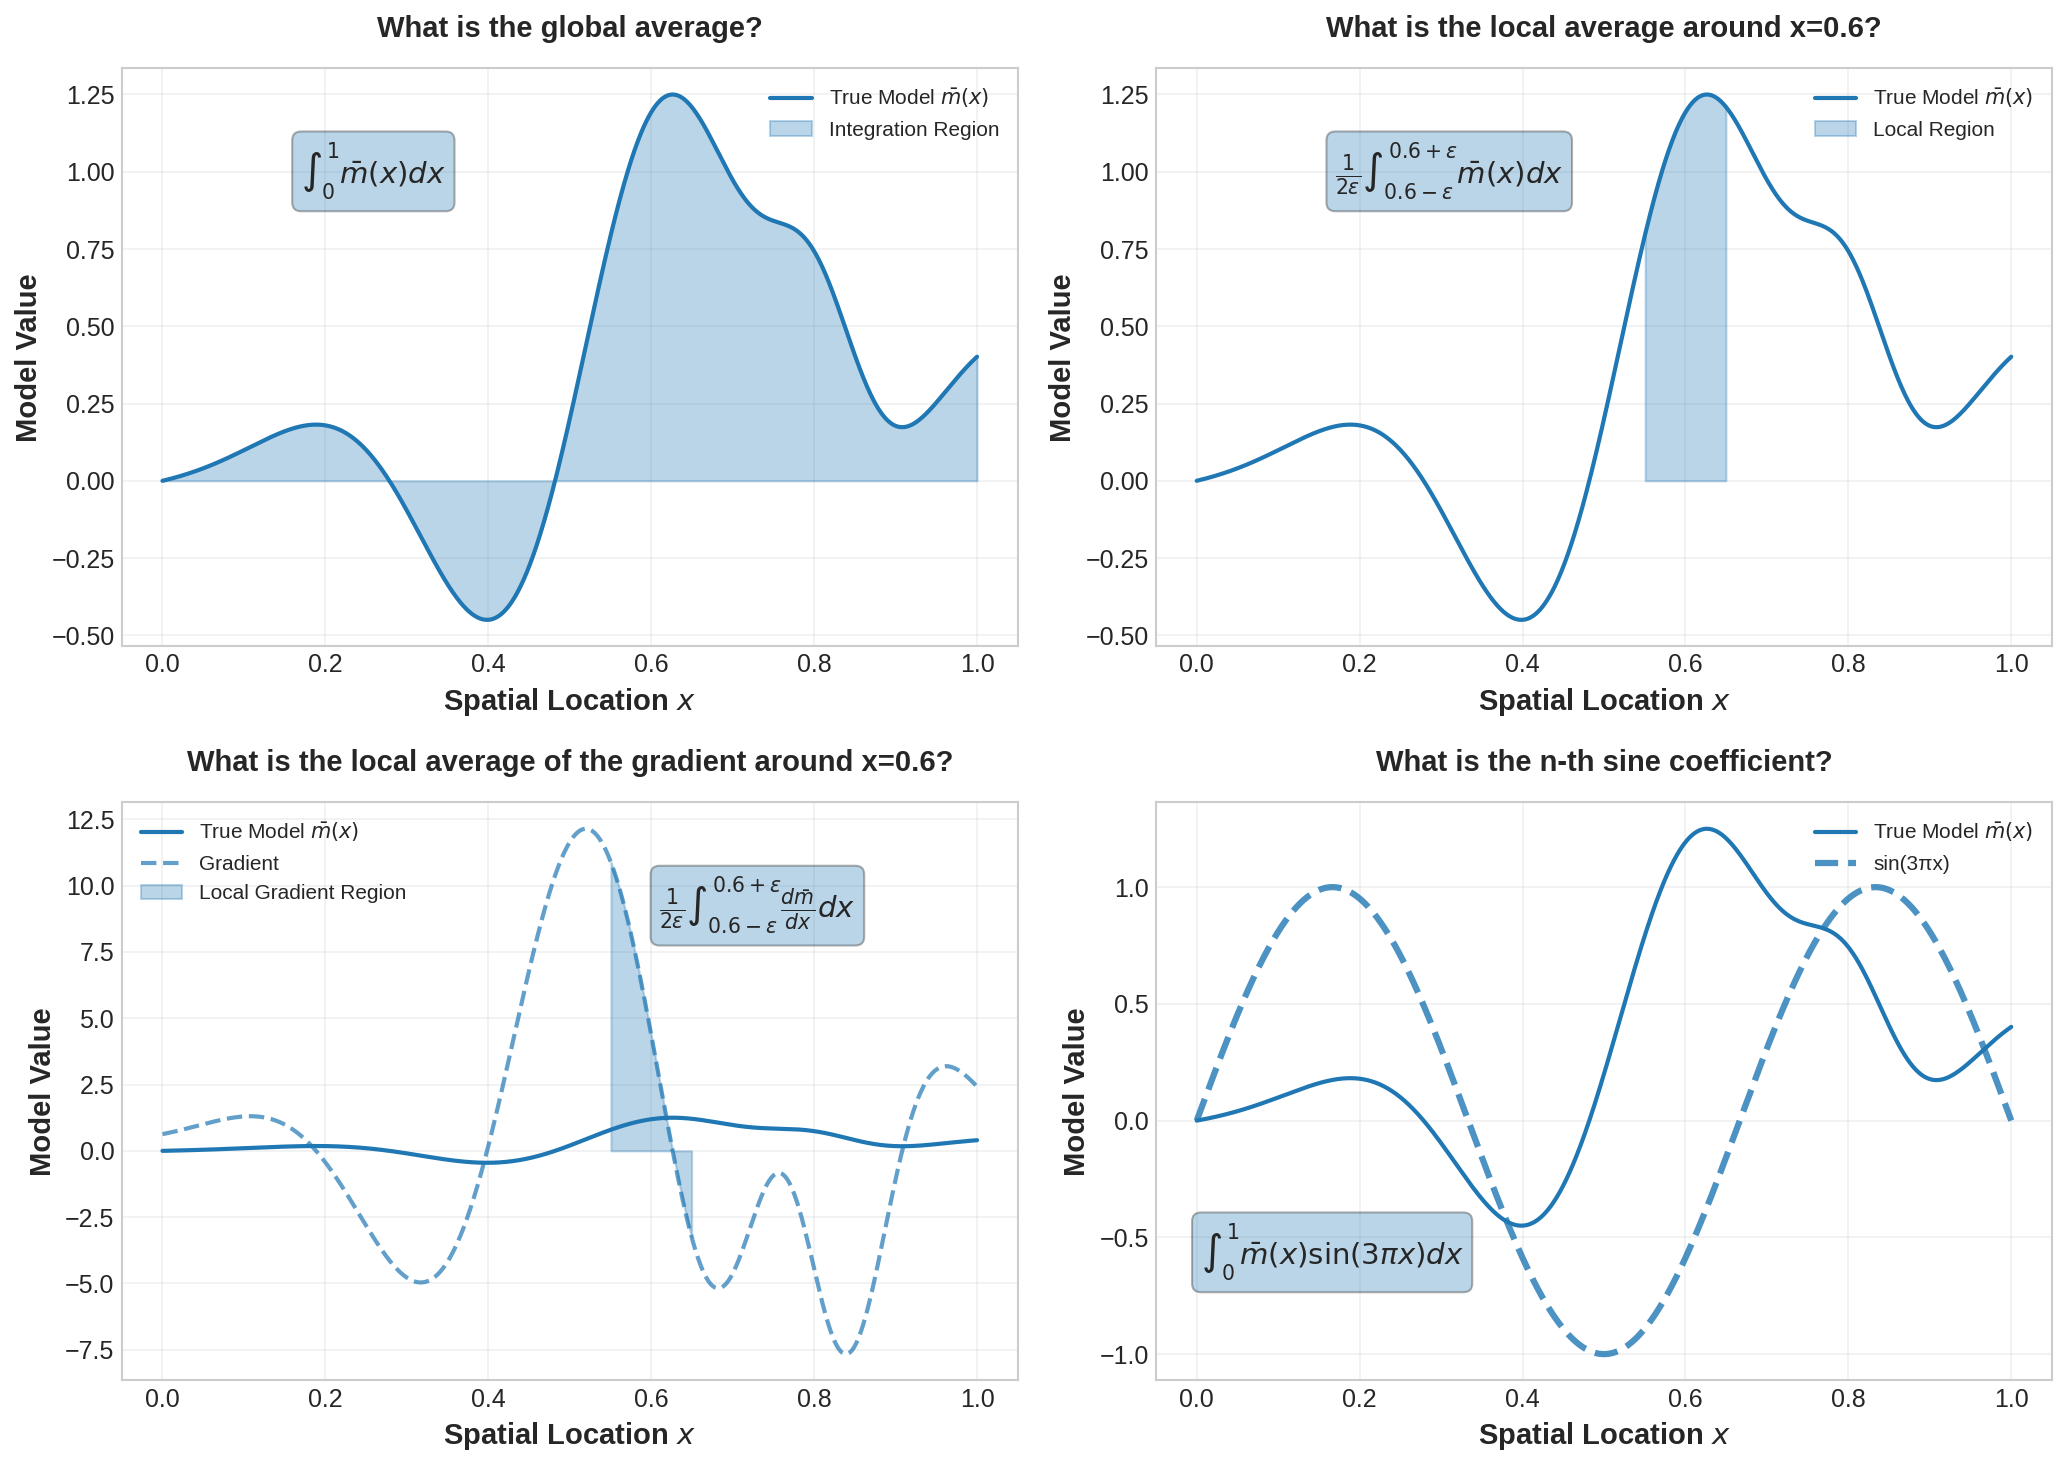

✅ Slide 4 figure saved: Challenge questions motivating linear inference


In [9]:
# Create figure for challenge questions (Slide 8)
def create_challenge_questions_frame(frame_number, save_prefix="slide4_challenge_questions"):
    """
    Create progressive animation frames for challenge questions.
    All frames have identical size and layout structure for easy alignment.

    Frame 1: Global average only
    Frame 2: Global average + Local gradient average
    Frame 3: Global average + Local gradient average + Local average
    Frame 4: All four questions (complete)
    """

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='white')

    # Questions to motivate linear inference
    questions = [
        "What is the global average?",
        "What is the local average around x=0.6?",
        "What is the local average of the gradient around x=0.6?",
        "What is the n-th sine coefficient?"
    ]

    # Control which subplots to show based on frame number
    active_subplots = []
    if frame_number >= 1:
        active_subplots.append(0)  # Global average
    if frame_number >= 2:
        active_subplots.append(1)  # Local average
    if frame_number >= 3:
        active_subplots.append(2)  # Local gradient average
    if frame_number >= 4:
        active_subplots.append(3)  # n-th sine coefficient

    # Process each subplot
    for idx, (ax, question) in enumerate(zip(axes.flat, questions)):
        if idx in active_subplots:
            # Plot True Model
            ax.plot(x_viz, m_true.evaluate(x_viz), color='tab:blue', linewidth=2,
                   label='True Model $\\bar{m}(x)$', zorder=10)

            # Highlight different regions/aspects for each question
            if idx == 0:  # Global average
                ax.fill_between(x_viz, m_true.evaluate(x_viz), alpha=0.3, color='tab:blue',
                               label='Integration Region')
                ax.text(0.2, 0.8, r'$\int_0^1 \bar{m}(x) dx$', fontsize=14, transform=ax.transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="tab:blue", alpha=0.3))

            elif idx == 1:  # Local average around x=0.6
                x_center = 0.6
                width = 0.1
                mask = (x_viz >= x_center - width/2) & (x_viz <= x_center + width/2)
                ax.fill_between(x_viz[mask], m_true.evaluate(x_viz)[mask], alpha=0.3,
                               color='tab:blue', label=f'Local Region')
                ax.text(0.2, 0.8, r'$\frac{1}{2\epsilon}\int_{0.6-\epsilon}^{0.6+\epsilon} \bar{m}(x) dx$',
                        fontsize=14, transform=ax.transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="tab:blue", alpha=0.3))

            elif idx == 2:  # Local average of gradient
                x_center = 0.6
                width = 0.1
                # Compute and plot gradient
                dm_dx = np.gradient(m_true.evaluate(x_viz), x_viz)
                ax.plot(x_viz, dm_dx, '--', color='tab:blue', linewidth=2, alpha=0.7, label='Gradient')
                # Highlight local region
                mask = (x_viz >= x_center - width/2) & (x_viz <= x_center + width/2)
                ax.fill_between(x_viz[mask], dm_dx[mask], alpha=0.3,
                               color='tab:blue', label=f'Local Gradient Region')
                ax.text(0.6, 0.8, r"$\frac{1}{2\epsilon}\int_{0.6-\epsilon}^{0.6+\epsilon} \frac{d \bar{m}}{dx} dx$",
                        fontsize=14, transform=ax.transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="tab:blue", alpha=0.3))

            elif idx == 3:  # n-th Fourier coefficient
                # Show the basis function for n-th Fourier mode
                n_fourier = 3  # Example: 3rd Fourier coefficient
                fourier_mode = np.sin(n_fourier * np.pi * x_viz)
                ax.plot(x_viz, fourier_mode, '--', linewidth=3, alpha=0.8,
                       label=f'sin({n_fourier}πx)', color='tab:blue')
                ax.text(0.05, 0.2, rf'$\int_0^1 \bar m(x) \sin({n_fourier}\pi x) dx$',
                        fontsize=14, transform=ax.transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="tab:blue", alpha=0.3))

            ax.set_title(question, fontsize=14, fontweight='bold', pad=15)
            ax.set_xlabel('Spatial Location $x$', fontweight='bold')
            ax.set_ylabel('Model Value', fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
        else:
            # Hide inactive subplots
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

    plt.tight_layout()

    # Save frame
    frame_filename = f'{save_prefix}_frame{frame_number}.png'
    plt.savefig(os.path.join(presentation_dir, frame_filename), dpi=300, bbox_inches='tight')

    return fig

# Generate all animation frames for challenge questions
print("🎬 Generating challenge questions animation frames for PowerPoint...")
for frame in range(1, 5):
    fig = create_challenge_questions_frame(frame)
    plt.close(fig)  # Close each frame to save memory
    print(f"   ✓ Frame {frame} saved")

# Create and display the final complete figure
print("📊 Creating final complete challenge questions figure...")
final_fig = create_challenge_questions_frame(4, "slide4_challenge_questions_complete")

plt.show()

print("✅ Slide 4 figure saved: Challenge questions motivating linear inference")

# Part 2: Linear Inference Framework

## The Solution: Property-Focused Inference

Instead of computing the full model posterior and then extracting properties, we directly target the **properties of interest**.

### Linear Inference Paradigm

**Key insight**: If we only care about linear functionals of the model, we can:
1. Define a **property space** $\mathcal{P}$ 
2. Create **target operators** $T: \mathcal{M} \to \mathcal{P}$ that extract properties
3. Compute **property posterior** $\mu_{\mathcal{P}}^{\tilde{\mathbf{d}}}$ directly

### Mathematical Framework

- **Target operator**: $T: \mathcal{M} \to \mathcal{P}$ (linear functional)
- **Property posterior**: $\mu_{\mathcal{P}}^{\tilde{\mathbf{d}}} = T_{\#}\mu_{\mathcal{M}}^{\tilde{\mathbf{d}}}$ (push-forward measure)
- **Gaussian structure**: If $\mu_{\mathcal{M}}^{\tilde{\mathbf{d}}}$ is Gaussian, then $\mu_{\mathcal{P}}^{\tilde{\mathbf{d}}}$ is also Gaussian

---

## Slide 5: Property Space and Target Operators

🎯 Setting up Linear Inference Framework...
📐 Property space: ℝ^1 (single local average)
✓ Target operator: Local uniform average around x=0.6
✓ Integration region: [0.5, 0.7]
✓ Kernel normalization: ∫ T(x) dx = 0.998


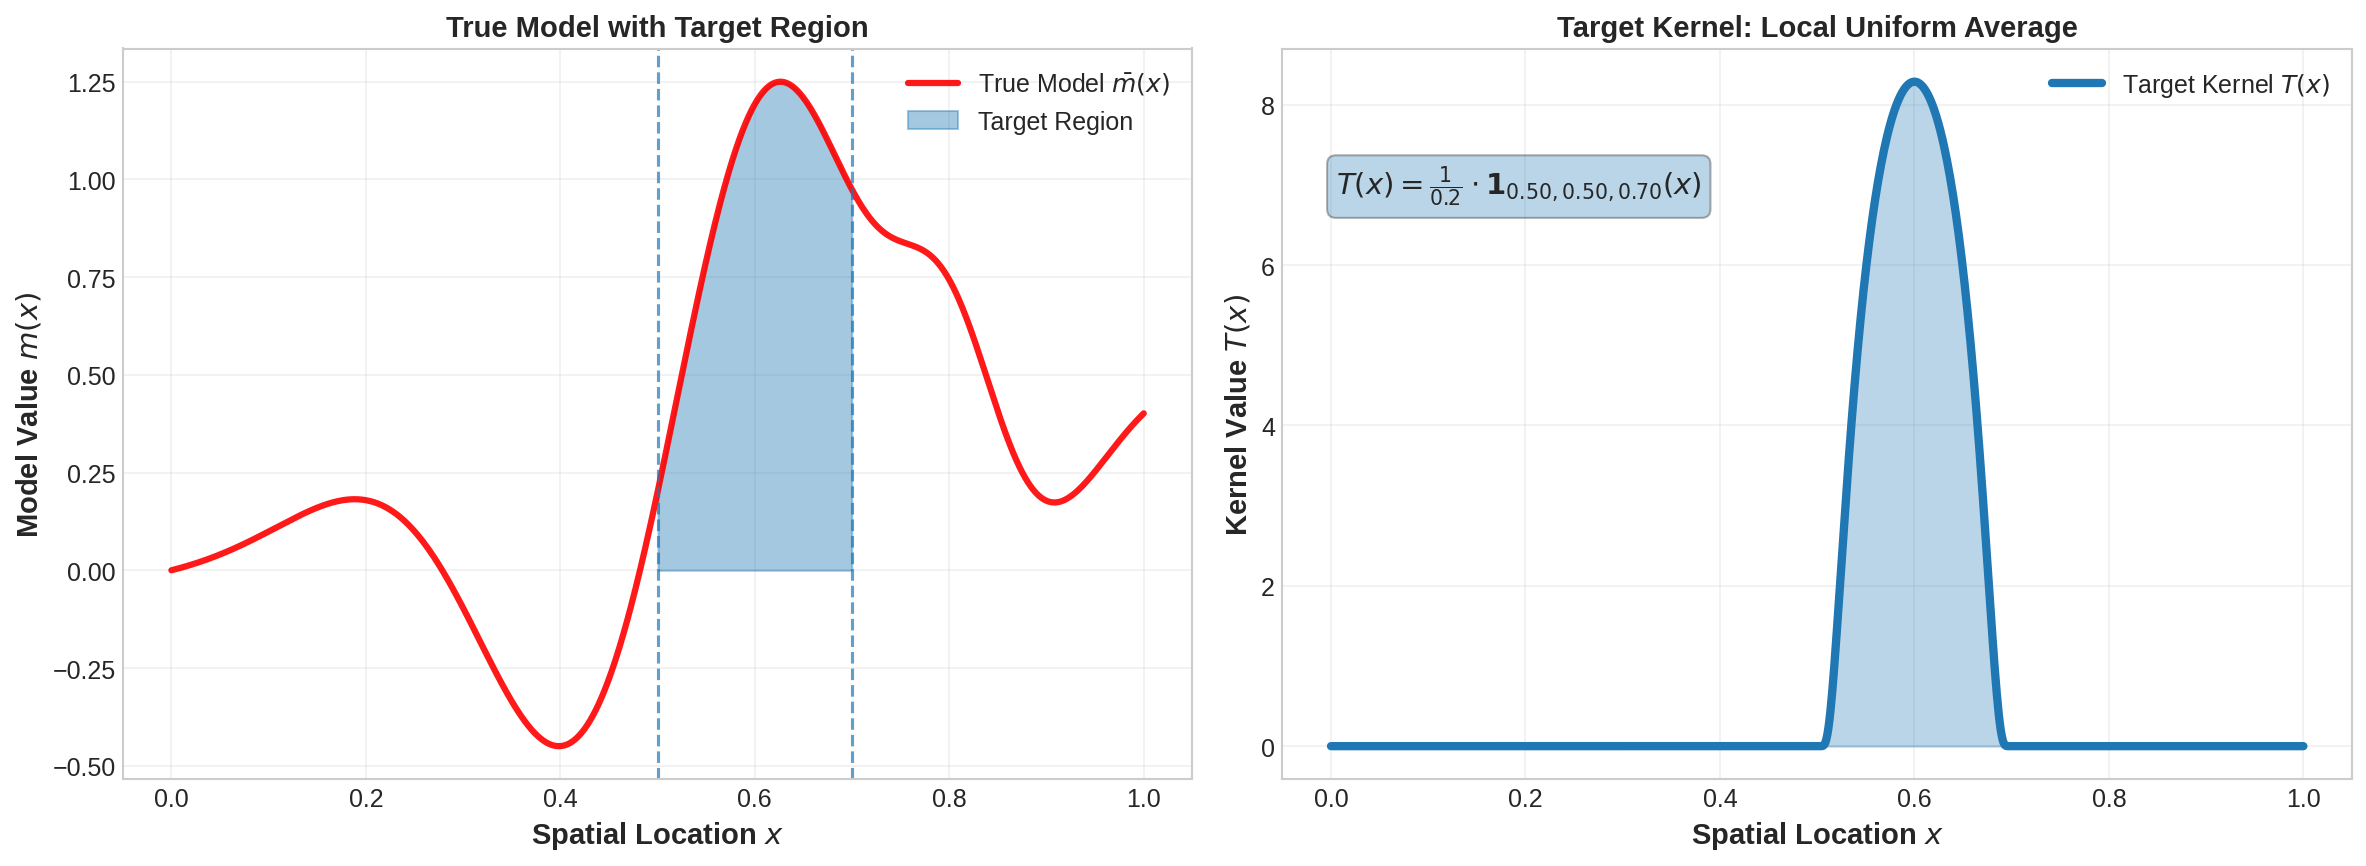

✅ Slide 5 figure saved: Target operator definition


In [10]:
# Define Property Space and Target Operator
print("🎯 Setting up Linear Inference Framework...")

# Property space (for now, 1D for local average)
N_PROPERTIES = 1  # Single property for local average
P = EuclideanSpace(N_PROPERTIES)
print(f"📐 Property space: ℝ^{P.dim} (single local average)")

# Target function parameters
width = 0.2
centers = np.array([0.6])  # Center of local average

# Create target operator using proper function provider
target_kernel_provider = BumpFunctionProvider(M, centers=centers, default_width=width)

print(f"✓ Target operator: Local uniform average around x={centers[0]}")
print(f"✓ Integration region: [{centers[0] - width/2:.1f}, {centers[0] + width/2:.1f}]")
print(f"✓ Kernel normalization: ∫ T(x) dx = {target_kernel_provider.get_function_by_index(0).integrate():.3f}")

# Visualize the target kerneltab:blue
fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor='white')

# Left panel: True model with target region
ax = axes[0]
ax.plot(x_viz, m_true.evaluate(x_viz), 'r-', linewidth=3, label='True Model $\\bar{m}(x)$', alpha=0.9)
ax.fill_between(x_viz, m_true.evaluate(x_viz),
                where=((x_viz >= centers[0] - width/2) & (x_viz <= centers[0] + width/2)),
                alpha=0.4, color='tab:blue', label='Target Region')
ax.axvline(centers[0] - width/2, color='tab:blue', linestyle='--', alpha=0.7)
ax.axvline(centers[0] + width/2, color='tab:blue', linestyle='--', alpha=0.7)

ax.set_xlabel('Spatial Location $x$', fontweight='bold')
ax.set_ylabel('Model Value $m(x)$', fontweight='bold')
ax.set_title('True Model with Target Region', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Right panel: Target kernel
ax = axes[1]
ax.plot(x_viz, target_kernel_provider.get_function_by_index(0).evaluate(x_viz), 'tab:blue', linewidth=4, label='Target Kernel $T(x)$')
ax.fill_between(x_viz, target_kernel_provider.get_function_by_index(0).evaluate(x_viz), alpha=0.3, color='tab:blue')

ax.set_xlabel('Spatial Location $x$', fontweight='bold')
ax.set_ylabel('Kernel Value $T(x)$', fontweight='bold')
ax.set_title('Target Kernel: Local Uniform Average', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Add mathematical description
ax.text(0.05, 0.8, f'$T(x) = \\frac{{1}}{{{width}}} \\cdot \\mathbf{{1}}_{{{centers[0] - width/2:.2f}, {centers[0] - width/2:.2f}, {centers[0] + width/2:.2f}}}(x)$',
        fontsize=14, transform=ax.transAxes,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="tab:blue", alpha=0.3))

plt.tight_layout()
plt.savefig(f'{presentation_dir}/slide5_target_operator.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Slide 5 figure saved: Target operator definition")

## Slide 6: Computing Linear Inference

### The Linear Inference Formula

For a linear target operator $T: \mathcal{M} \to \mathcal{P}$, the property posterior is:

$$\mu_{\mathcal{P}}^{\tilde{\mathbf{d}}} = \mathcal{N}(\hat{p}, \sigma_p^2)$$

where:
- **Property mean**: $\hat{p} = T(\tilde{m})$ 
- **Property variance**: $\sigma_p^2 = T(C_{\mathcal{M}} T^*)$

### Key Advantages

1. **Direct computation**: No need to sample from model posterior
2. **Exact uncertainty**: Analytical variance computation
3. **Computational efficiency**: Avoid high-dimensional sampling
4. **Property-focused**: Get exactly what you need

### Implementation Steps

1. Compute model posterior $\mu_{\mathcal{M}}^{\tilde{\mathbf{d}}}$ (as before)
2. Apply target operator to posterior mean: $\hat{p} = T(\tilde{m})$
3. Compute property uncertainty: $\sigma_p^2 = T(C_{\mathcal{M}} T^*)$

In [11]:
# Compute Linear Inference using PyGeoInf framework
print("🔄 Computing linear inference using PyGeoInf framework...")

# Import linear inference class
from pygeoinf.bayesian import LinearBayesianInference


T = SOLAOperator(M, P, target_kernel_provider, integration_method='trapz', n_points=1000)

# Create linear inference object
linear_inference = LinearBayesianInference(forward_problem, M.gaussian_measure, T)

# Compute property posterior measure directly using PyGeoInf
print("📊 Computing property posterior measure...")
property_posterior = linear_inference.property_posterior_measure(d_tilde, solver)

# Extract property mean and standard deviation from the posterior measure
property_mean = property_posterior.expectation  # First (and only) component

# Get the variance properly from the GaussianMeasure
property_cov = property_posterior.covariance.matrix(dense=True)
property_std = np.sqrt(np.diag(property_cov))

# Compute true property
true_property = T(m_true)

# Compare with true value
print(f"🎯 True property value: {true_property[0]:.4f}")
print(f"📊 Inference error: {abs(property_mean[0] - true_property[0]):.4f}")
print(f"📊 Error in standard deviations: {abs(property_mean[0] - true_property[0])/property_std[0]:.2f}σ")

print("✅ Linear inference computation completed using PyGeoInf framework")

🔄 Computing linear inference using PyGeoInf framework...
📊 Computing property posterior measure...
🎯 True property value: 1.0740
📊 Inference error: 0.0904
📊 Error in standard deviations: 0.31σ
✅ Linear inference computation completed using PyGeoInf framework
🎯 True property value: 1.0740
📊 Inference error: 0.0904
📊 Error in standard deviations: 0.31σ
✅ Linear inference computation completed using PyGeoInf framework


🎨 Creating visualization of linear inference results...


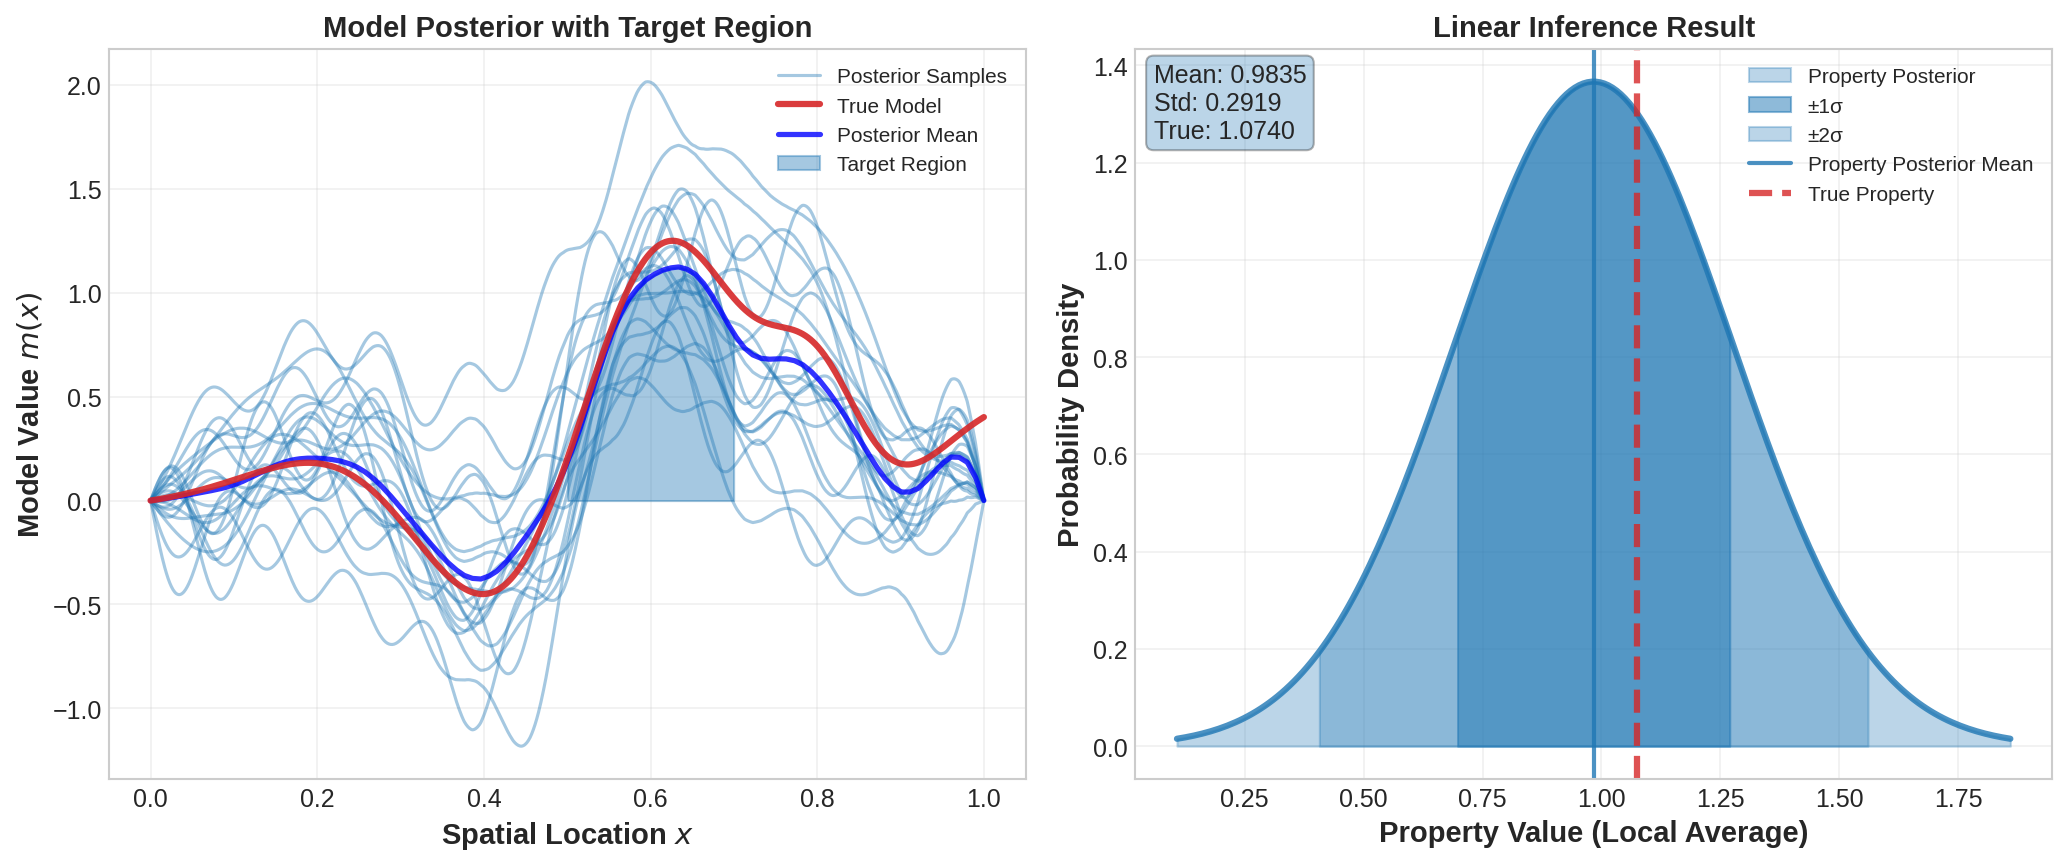

✅ Slide 6 figure saved: Linear inference computation and results


In [12]:
# Visualize Linear Inference Results
print("🎨 Creating visualization of linear inference results...")

# Create visualization of inference results
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')

# Left panel: Model posterior with target region
ax = axes[0]
# Show some posterior samples (approximation for visualization)
np.random.seed(RANDOM_SEED)
for i in range(n_post_samples):
    sample_values = mu_M.sample().evaluate(x_viz)
    ax.plot(x_viz, sample_values, color='tab:blue', alpha=sample_alpha, linewidth=1.5,
             label='Posterior Samples' if i == 0 else "")

ax.plot(x_viz, m_true.evaluate(x_viz), '-', color='tab:red', linewidth=3, label='True Model', alpha=0.9, zorder=10)
ax.plot(x_viz, posterior_mean.evaluate(x_viz), 'b-', linewidth=2.5, label='Posterior Mean', alpha=0.8, zorder=9)

# Highlight target region
target_values = target_kernel_provider.get_function_by_index(0).evaluate(x_viz)
ax.fill_between(x_viz, posterior_mean.evaluate(x_viz),
                where=((x_viz >= centers[0] - width/2) & (x_viz <= centers[0] + width/2)),
                alpha=0.4, color='tab:blue', label='Target Region')

ax.set_xlabel('Spatial Location $x$', fontweight='bold')
ax.set_ylabel('Model Value $m(x)$', fontweight='bold')
ax.set_title('Model Posterior with Target Region', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right panel: Property posterior as Gaussian
ax = axes[1]
# Create a nicer Gaussian visualization using the exact posterior from PyGeoInf
x_fine = np.linspace(property_mean[0] - 3*property_std[0], property_mean[0] + 3*property_std[0], 200)
y_fine = (1/(property_std[0] * np.sqrt(2*np.pi))) * np.exp(-0.5*((x_fine - property_mean[0])/property_std[0])**2)

ax.fill_between(x_fine, y_fine, alpha=0.3, color='tab:blue', label='Property Posterior')
ax.plot(x_fine, y_fine, '-', color='tab:blue', linewidth=3, alpha=0.8)

# Add confidence intervals
ax.fill_between(x_fine, y_fine,
                where=((x_fine >= property_mean - property_std) & (x_fine <= property_mean + property_std)),
                alpha=0.5, color='tab:blue', label='±1σ')
ax.fill_between(x_fine, y_fine,
                where=((x_fine >= property_mean - 2*property_std) & (x_fine <= property_mean + 2*property_std)),
                alpha=0.3, color='tab:blue', label='±2σ')

# Mark key values
ax.axvline(property_mean, color='tab:blue', linestyle='-', linewidth=2, alpha=0.8, label='Property Posterior Mean')
ax.axvline(true_property[0], color='tab:red', linestyle='--', linewidth=3, alpha=0.8, label='True Property')

ax.set_xlabel('Property Value (Local Average)', fontweight='bold')
ax.set_ylabel('Probability Density', fontweight='bold')
ax.set_title('Linear Inference Result', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Add text summary
textstr = f'Mean: {property_mean[0]:.4f}\nStd: {property_std[0]:.4f}\nTrue: {true_property[0]:.4f}'
props = dict(boxstyle='round', facecolor='tab:blue', alpha=0.3)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(f'{presentation_dir}/slide6_linear_inference_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Slide 6 figure saved: Linear inference computation and results")

## Summary: From Inversions to Linear Inferences

### Key Results of Part 2:

**Property Space Framework:**
- Introduced property space $P = \mathbb{R}^1$ for local averaging
- Defined target operator $T: M \to P$ as uniform local average around $x = 0.6$
- Applied linear inference paradigm: $\mu_P^{\tilde{d}} = T(\mu_M^{\tilde{d}})$

**Linear Inference Benefits:**
1. **Direct Property Estimation**: Skip model reconstruction, directly infer properties of interest
2. **Uncertainty Quantification**: Gaussian property posterior with exact mean and variance
3. **Computational Efficiency**: No need to solve full inverse problem
4. **Natural Uncertainty Propagation**: Model uncertainty automatically transfers to property uncertainty

**Comparison with Traditional Inversion:**
- **Traditional**: Model reconstruction → Property evaluation from model
- **Linear Inference**: Data → Property posterior directly
- **Advantage**: More efficient and often more robust for specific property queries

### Mathematical Framework Recap:
$$\text{Property Posterior: } \mu_P^{\tilde{d}} \sim \mathcal{N}(\hat{p}, \sigma_p^2)$$

where $\hat{p} = T(\hat{m})$ and $\sigma_p^2$ incorporates both data and model uncertainties through the linear operator $T$.

---

**Next Steps**: Extension to multiple properties, non-linear target operators, and practical applications in geophysical inference problems.

## Multi-k Bump Function Analysis

In this section, we investigate how the shape parameter $k$ in the bump function affects both:
1. **Target kernel shape**: The spatial structure of our target operator
2. **Linear inference results**: The property posterior distribution

We'll analyze $k$ values from 0 to 10, where:
- $k = 0$: Box-like function (sharp boundaries)  
- $k \to \infty$: Gaussian-like function (smooth boundaries)

The generalized bump function is given by:
$$\phi_k(t) = \frac{1}{Z_k} \exp\left(\frac{k \cdot t}{t^2 - 1}\right) \quad \text{for } t \in (-1, 1)$$

where $Z_k$ is the normalization constant ensuring $\int_{-1}^{1} \phi_k(t) \, dt = 1$.

In [30]:
# Simplified Multi-k Bump Function Analysis
print("🔬 Starting Simplified Multi-k Bump Function Analysis...")

# Define k values to analyze
k_values = np.concatenate(([0.0], np.logspace(-3, 1, 59)))
print(f"📊 Analyzing k values: {k_values}")

# Setup for single target location analysis
P_single = EuclideanSpace(1)  # Single property
center_single = 0.6  # Single target location
width_single = 0.15

print(f"🎯 Target location: {center_single}")
print(f"📏 Target width: {width_single}")

# Storage for simplified results
results_simple = {
    'k_values': k_values,
    'property_means': [],
    'property_stds': [],
    'target_kernels': [],
    'true_values': [],
    'computation_success': []
}

import concurrent.futures

def analyze_k(k):
    try:
        # All imports and definitions that are needed inside the subprocess
        from pygeoinf.interval.function_providers import BumpFunctionProvider
        from pygeoinf.bayesian import LinearBayesianInference
        from pygeoinf.interval.operators import SOLAOperator
        import numpy as np

        # These variables must be global or passed as arguments if not available in the subprocess
        target_provider_k = BumpFunctionProvider(
            M,
            centers=np.array([center_single]),
            default_width=width_single,
            default_k=k
        )
        T_k = SOLAOperator(M, P_single, target_provider_k, integration_method='trapz', n_points=1000)
        linear_inference_k = LinearBayesianInference(forward_problem, M.gaussian_measure, T_k)
        property_posterior_k = linear_inference_k.property_posterior_measure(d_tilde, solver)
        prop_mean = property_posterior_k.expectation[0]
        prop_cov = property_posterior_k.covariance.matrix(dense=True)
        prop_std = np.sqrt(prop_cov[0, 0])
        true_prop = T_k(m_true)[0]
        target_kernel = target_provider_k.get_function_by_index(0).evaluate(x_viz)
        return (prop_mean, prop_std, target_kernel, true_prop, True, None)
    except Exception as e:
        return (0.0, 0.0, np.zeros_like(x_viz), 0.0, False, str(e))

print("🔬 Starting Parallel Multi-k Bump Function Analysis...")

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(analyze_k, k_values))

# Unpack results
results_simple = {
    'k_values': k_values,
    'property_means': [],
    'property_stds': [],
    'target_kernels': [],
    'true_values': [],
    'computation_success': []
}
for i, (prop_mean, prop_std, target_kernel, true_prop, success, err) in enumerate(results):
    if success:
        print(f"   ✓ Success - Mean: {prop_mean:.4f}, Std: {prop_std:.4f}, True: {true_prop:.4f}")
    else:
        print(f"   ❌ Failed for k={k_values[i]} - Error: {err}")
    results_simple['property_means'].append(prop_mean)
    results_simple['property_stds'].append(prop_std)
    results_simple['target_kernels'].append(target_kernel)
    results_simple['true_values'].append(true_prop)
    results_simple['computation_success'].append(success)

print(f"\n✅ Parallel multi-k analysis completed")
print(f"📊 Successful computations: {sum(results_simple['computation_success'])}/{len(k_values)}")

🔬 Starting Simplified Multi-k Bump Function Analysis...
📊 Analyzing k values: [0.00000000e+00 1.00000000e-03 1.17210230e-03 1.37382380e-03
 1.61026203e-03 1.88739182e-03 2.21221629e-03 2.59294380e-03
 3.03919538e-03 3.56224789e-03 4.17531894e-03 4.89390092e-03
 5.73615251e-03 6.72335754e-03 7.88046282e-03 9.23670857e-03
 1.08263673e-02 1.26896100e-02 1.48735211e-02 1.74332882e-02
 2.04335972e-02 2.39502662e-02 2.80721620e-02 3.29034456e-02
 3.85662042e-02 4.52035366e-02 5.29831691e-02 6.21016942e-02
 7.27895384e-02 8.53167852e-02 1.00000000e-01 1.17210230e-01
 1.37382380e-01 1.61026203e-01 1.88739182e-01 2.21221629e-01
 2.59294380e-01 3.03919538e-01 3.56224789e-01 4.17531894e-01
 4.89390092e-01 5.73615251e-01 6.72335754e-01 7.88046282e-01
 9.23670857e-01 1.08263673e+00 1.26896100e+00 1.48735211e+00
 1.74332882e+00 2.04335972e+00 2.39502662e+00 2.80721620e+00
 3.29034456e+00 3.85662042e+00 4.52035366e+00 5.29831691e+00
 6.21016942e+00 7.27895384e+00 8.53167852e+00 1.00000000e+01]
🎯 Targ

🎬 Creating efficient video for multi-k bump function analysis...
📊 Pre-computing expensive operations...
🎲 Pre-generating posterior samples...
✅ Pre-computation completed
🎥 Creating frames (this should be much faster)...
   Creating frame 1/60: k = 0.0
   Creating frame 2/60: k = 0.001
   Creating frame 2/60: k = 0.001
   Creating frame 3/60: k = 0.0011721022975334804
   Creating frame 3/60: k = 0.0011721022975334804
   Creating frame 4/60: k = 0.0013738237958832624
   Creating frame 4/60: k = 0.0013738237958832624
   Creating frame 5/60: k = 0.0016102620275609393
   Creating frame 5/60: k = 0.0016102620275609393
   Creating frame 6/60: k = 0.0018873918221350976
   Creating frame 6/60: k = 0.0018873918221350976
   Creating frame 7/60: k = 0.00221221629107045
   Creating frame 7/60: k = 0.00221221629107045
   Creating frame 8/60: k = 0.002592943797404667
   Creating frame 8/60: k = 0.002592943797404667
   Creating frame 9/60: k = 0.0030391953823131978
   Creating frame 9/60: k = 0.00303

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2066, 852) to (2080, 864) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ MP4 video created successfully: conference_presentation_figures/multi_k_analysis_video.mp4 (fps=12, duration~5.00s)
📺 Displaying example frame...


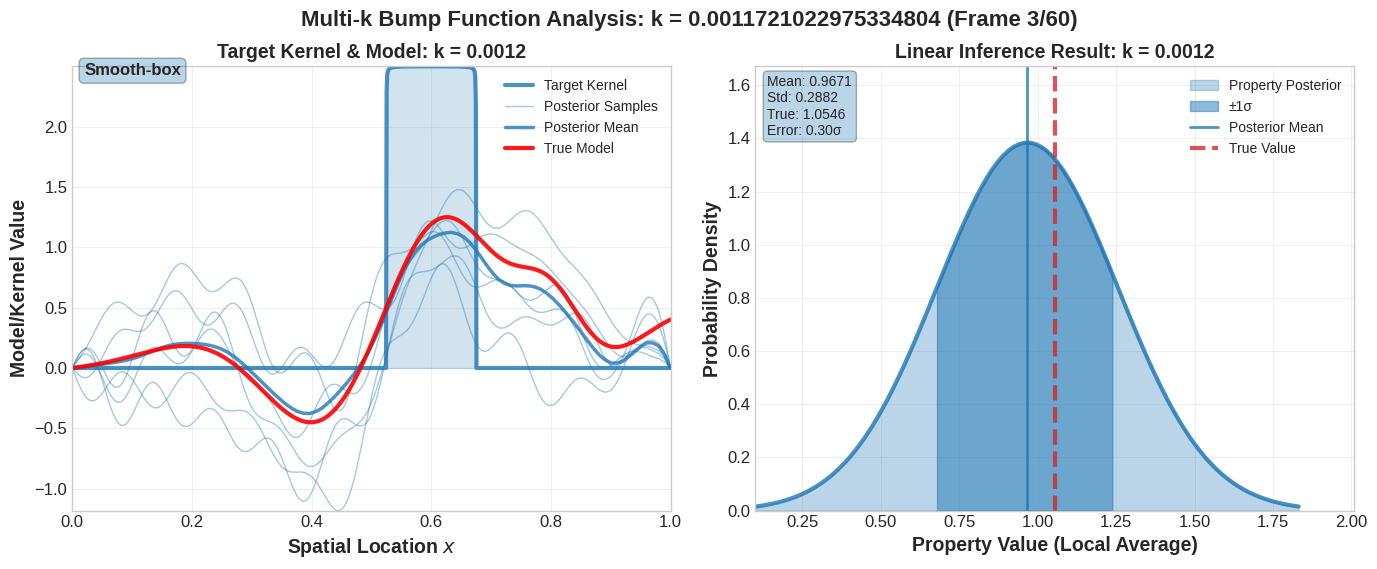

🎬 Efficient animation creation completed!
📁 Frames saved in: conference_presentation_figures/k_animation_frames
🎥 Video location: conference_presentation_figures
⚡ Performance improvements:
   • Pre-computed expensive operations
   • Reduced sample count from 8 to 6
   • Sequential frame generation (no FuncAnimation)
   • Lower DPI for faster rendering


In [31]:
# Create Efficient Video Visualization for Each k Value
print("🎬 Creating efficient video for multi-k bump function analysis...")

import os
from matplotlib.backends.backend_agg import FigureCanvasAgg

# Pre-compute expensive operations once
print("📊 Pre-computing expensive operations...")

# Pre-compute model evaluations (expensive operations)
true_model_vals = m_true.evaluate(x_viz)
true_model_max = np.max(np.abs(true_model_vals))
posterior_mean_vals = posterior_mean.evaluate(x_viz)

# Pre-compute posterior samples once (this was the main bottleneck)
print("🎲 Pre-generating posterior samples...")
np.random.seed(RANDOM_SEED)
n_vis_samples = 6  # Reduced for performance
precomputed_samples = []
for i in range(n_vis_samples):
    sample_vals = mu_M.sample().evaluate(x_viz)
    precomputed_samples.append(sample_vals)

print("✅ Pre-computation completed")

def create_efficient_k_frame(k_idx, k_value, results):
    """Create a single frame efficiently for a specific k value"""

    # Create figure with single row (2 panels)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor='white', dpi=100)  # Reduced DPI for speed

    if results['computation_success'][k_idx]:
        # Left panel: Target kernel with model information
        ax_left = axes[0]

        # Scale target kernel (pre-computed)
        raw_kernel = results['target_kernels'][k_idx]
        kernel_max = np.max(np.abs(raw_kernel))
        if kernel_max > 0:
            scale_factor = (2 * true_model_max) / kernel_max
            scaled_kernel = raw_kernel * scale_factor
        else:
            scaled_kernel = raw_kernel

        # Plot scaled target kernel
        ax_left.plot(x_viz, scaled_kernel, 'tab:blue', linewidth=3, alpha=0.8, label='Target Kernel')
        ax_left.fill_between(x_viz, scaled_kernel, alpha=0.2, color='tab:blue')

        # Plot pre-computed posterior samples
        for j, sample_vals in enumerate(precomputed_samples):
            ax_left.plot(x_viz, sample_vals, color='tab:blue', alpha=0.4, linewidth=1,
                        label='Posterior Samples' if j == 0 else "")

        # Plot posterior mean (pre-computed)
        ax_left.plot(x_viz, posterior_mean_vals, color='tab:blue', linewidth=2.5, alpha=0.8, label='Posterior Mean')

        # Plot true model (pre-computed)
        ax_left.plot(x_viz, true_model_vals, 'r-', linewidth=3, alpha=0.9, label='True Model')

        ax_left.set_xlabel('Spatial Location $x$', fontweight='bold')
        ax_left.set_ylabel('Model/Kernel Value', fontweight='bold')
        ax_left.set_title(f'Target Kernel & Model: k = {k_value:.4f}', fontweight='bold', fontsize=14)
        ax_left.legend(fontsize=10)
        ax_left.grid(True, alpha=0.3)

        # Add shape classification
        if k_value == 0.0:
            shape_type = "Box-like"
        elif k_value < 0.1:
            shape_type = "Smooth-box"
        elif k_value < 1.0:
            shape_type = "Bump-like"
        else:
            shape_type = "Gaussian-like"

        ax_left.text(0.02, 0.98, shape_type, transform=ax_left.transAxes,
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='tab:blue', alpha=0.3))

        # Right panel: Linear inference result (Gaussian)
        ax_right = axes[1]
        prop_mean = results['property_means'][k_idx]
        prop_std = results['property_stds'][k_idx]
        true_val = results['true_values'][k_idx]

        # Create Gaussian visualization
        x_range = np.linspace(prop_mean - 3*prop_std, prop_mean + 3*prop_std, 100)  # Reduced points
        y_gauss = (1/(prop_std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x_range - prop_mean)/prop_std)**2)

        ax_right.fill_between(x_range, y_gauss, alpha=0.3, color='tab:blue', label='Property Posterior')
        ax_right.plot(x_range, y_gauss, '-', color='tab:blue', linewidth=3, alpha=0.8)

        # Add confidence intervals
        ax_right.fill_between(x_range, y_gauss,
                            where=((x_range >= prop_mean - prop_std) & (x_range <= prop_mean + prop_std)),
                            alpha=0.5, color='tab:blue', label='±1σ')

        # Mark key values
        ax_right.axvline(prop_mean, color='tab:blue', linestyle='-', linewidth=2, alpha=0.8,
                        label='Posterior Mean')
        ax_right.axvline(true_val, color='tab:red', linestyle='--', linewidth=3, alpha=0.8,
                        label='True Value')

        ax_right.set_xlabel('Property Value (Local Average)', fontweight='bold')
        ax_right.set_ylabel('Probability Density', fontweight='bold')
        ax_right.set_title(f'Linear Inference Result: k = {k_value:.4f}', fontweight='bold', fontsize=14)
        ax_right.legend(fontsize=10)
        ax_right.grid(True, alpha=0.3)

        # Add text summary
        error = abs(prop_mean - true_val)
        error_in_sigmas = error / prop_std if prop_std > 0 else 0
        textstr = f'Mean: {prop_mean:.4f}\nStd: {prop_std:.4f}\nTrue: {true_val:.4f}\nError: {error_in_sigmas:.2f}σ'
        props = dict(boxstyle='round', facecolor='tab:blue', alpha=0.3)
        ax_right.text(0.02, 0.98, textstr, transform=ax_right.transAxes, fontsize=10,
                     verticalalignment='top', bbox=props)

    else:
        # Handle failed computations
        for j in range(2):
            axes[j].text(0.5, 0.5, f'FAILED\nCOMPUTATION\nk = {k_value}',
                        transform=axes[j].transAxes, fontsize=14, fontweight='bold',
                        ha='center', va='center', color='red')
            axes[j].set_title(f'k = {k_value} (Failed)', fontweight='bold')

    ax_left.set_xlim(xlim_left)
    ax_left.set_ylim(ylim_left)
    ax_right.set_xlim(xlim_right)
    ax_right.set_ylim(ylim_right)
    # Add overall title with progress indicator
    plt.suptitle(f'Multi-k Bump Function Analysis: k = {k_value} (Frame {k_idx+1}/{len(k_values)})',
                fontsize=16, fontweight='bold', y=0.95)

    plt.tight_layout()
    return fig

# Create frames directory
frames_dir = os.path.join(presentation_dir, 'k_animation_frames')
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# For left panel (model/kernel)
xlim_left = (x_viz[0], x_viz[-1])
# Compute y-limits across all possible curves to be shown
yvals_left = [true_model_vals, posterior_mean_vals]
for s in precomputed_samples:
    yvals_left.append(s)
for kernel in results_simple['target_kernels']:
    yvals_left.append(kernel * (2 * true_model_max) / (np.max(np.abs(kernel)) if np.max(np.abs(kernel)) > 0 else 1))
ylim_left = (min([np.min(y) for y in yvals_left]), max([np.max(y) for y in yvals_left]))

# For right panel (Gaussian)
all_means = results_simple['property_means']
all_stds = results_simple['property_stds']
xlim_right = (min([m - 3*s for m, s in zip(all_means, all_stds)]), max([m + 3*s for m, s in zip(all_means, all_stds)]))
# For y, just use a fixed upper bound (e.g., 1.2 * max peak of all Gaussians)
import numpy as np
ymax_right = 0
for m, s in zip(all_means, all_stds):
    if s > 0:
        peak = 1/(s * np.sqrt(2*np.pi))
        if peak > ymax_right:
            ymax_right = peak
ylim_right = (0, 1.2 * ymax_right)

# Generate individual frames efficiently
print("🎥 Creating frames (this should be much faster)...")
frame_files = []

for i, k in enumerate(k_values):
    print(f"   Creating frame {i+1}/{len(k_values)}: k = {k}")

    # Create frame
    fig = create_efficient_k_frame(i, k, results_simple)

    # Save frame
    frame_filename = os.path.join(frames_dir, f'frame_{i:02d}_k_{k}.png')
    fig.savefig(frame_filename, dpi=150, bbox_inches='tight', facecolor='white')
    frame_files.append(frame_filename)

    # Close to save memory
    plt.close(fig)

print(f"✅ Created {len(frame_files)} frames successfully")

# Try to create video using imageio (more reliable than matplotlib animation)
try:
    print("📹 Creating MP4 video using imageio...")
    import imageio.v2 as imageio

    # Read all frames
    images = []
    for frame_file in frame_files:
        images.append(imageio.imread(frame_file))

    # Calculate fps for ≤ 5 seconds total duration
    N = len(frame_files)
    fps = max(1, int(np.ceil(N / 5)))  # at least 1 fps

    # Create video
    mp4_filename = os.path.join(presentation_dir, 'multi_k_analysis_video.mp4')
    imageio.mimsave(mp4_filename, images, fps=fps, format='mp4')
    print(f"✅ MP4 video created successfully: {mp4_filename} (fps={fps}, duration~{N/fps:.2f}s)")

except ImportError:
    print("⚠️ imageio not available, trying alternative method...")

    # Alternative: Create GIF using PIL
    try:
        from PIL import Image

        print("🎨 Creating GIF using PIL...")
        images = [Image.open(frame_file) for frame_file in frame_files]

        gif_filename = os.path.join(presentation_dir, 'multi_k_analysis_animation.gif')
        images[0].save(
            gif_filename,
            save_all=True,
            append_images=images[1:],
            duration=2000,  # 2 seconds per frame
            loop=0
        )
        print(f"✅ GIF animation created successfully: {gif_filename}")

    except Exception as e:
        print(f"❌ Could not create video: {e}")
        print(f"📁 Individual frames are available in: {frames_dir}")

# Display one example frame
print("📺 Displaying example frame...")
example_fig = create_efficient_k_frame(2, k_values[2], results_simple)  # Show k=0.5 frame
plt.show()
plt.close(example_fig)

print("🎬 Efficient animation creation completed!")
print(f"📁 Frames saved in: {frames_dir}")
print(f"🎥 Video location: {presentation_dir}")
print(f"⚡ Performance improvements:")
print(f"   • Pre-computed expensive operations")
print(f"   • Reduced sample count from 8 to {n_vis_samples}")
print(f"   • Sequential frame generation (no FuncAnimation)")
print(f"   • Lower DPI for faster rendering")

📊 Summary of multi-k bump function analysis results...


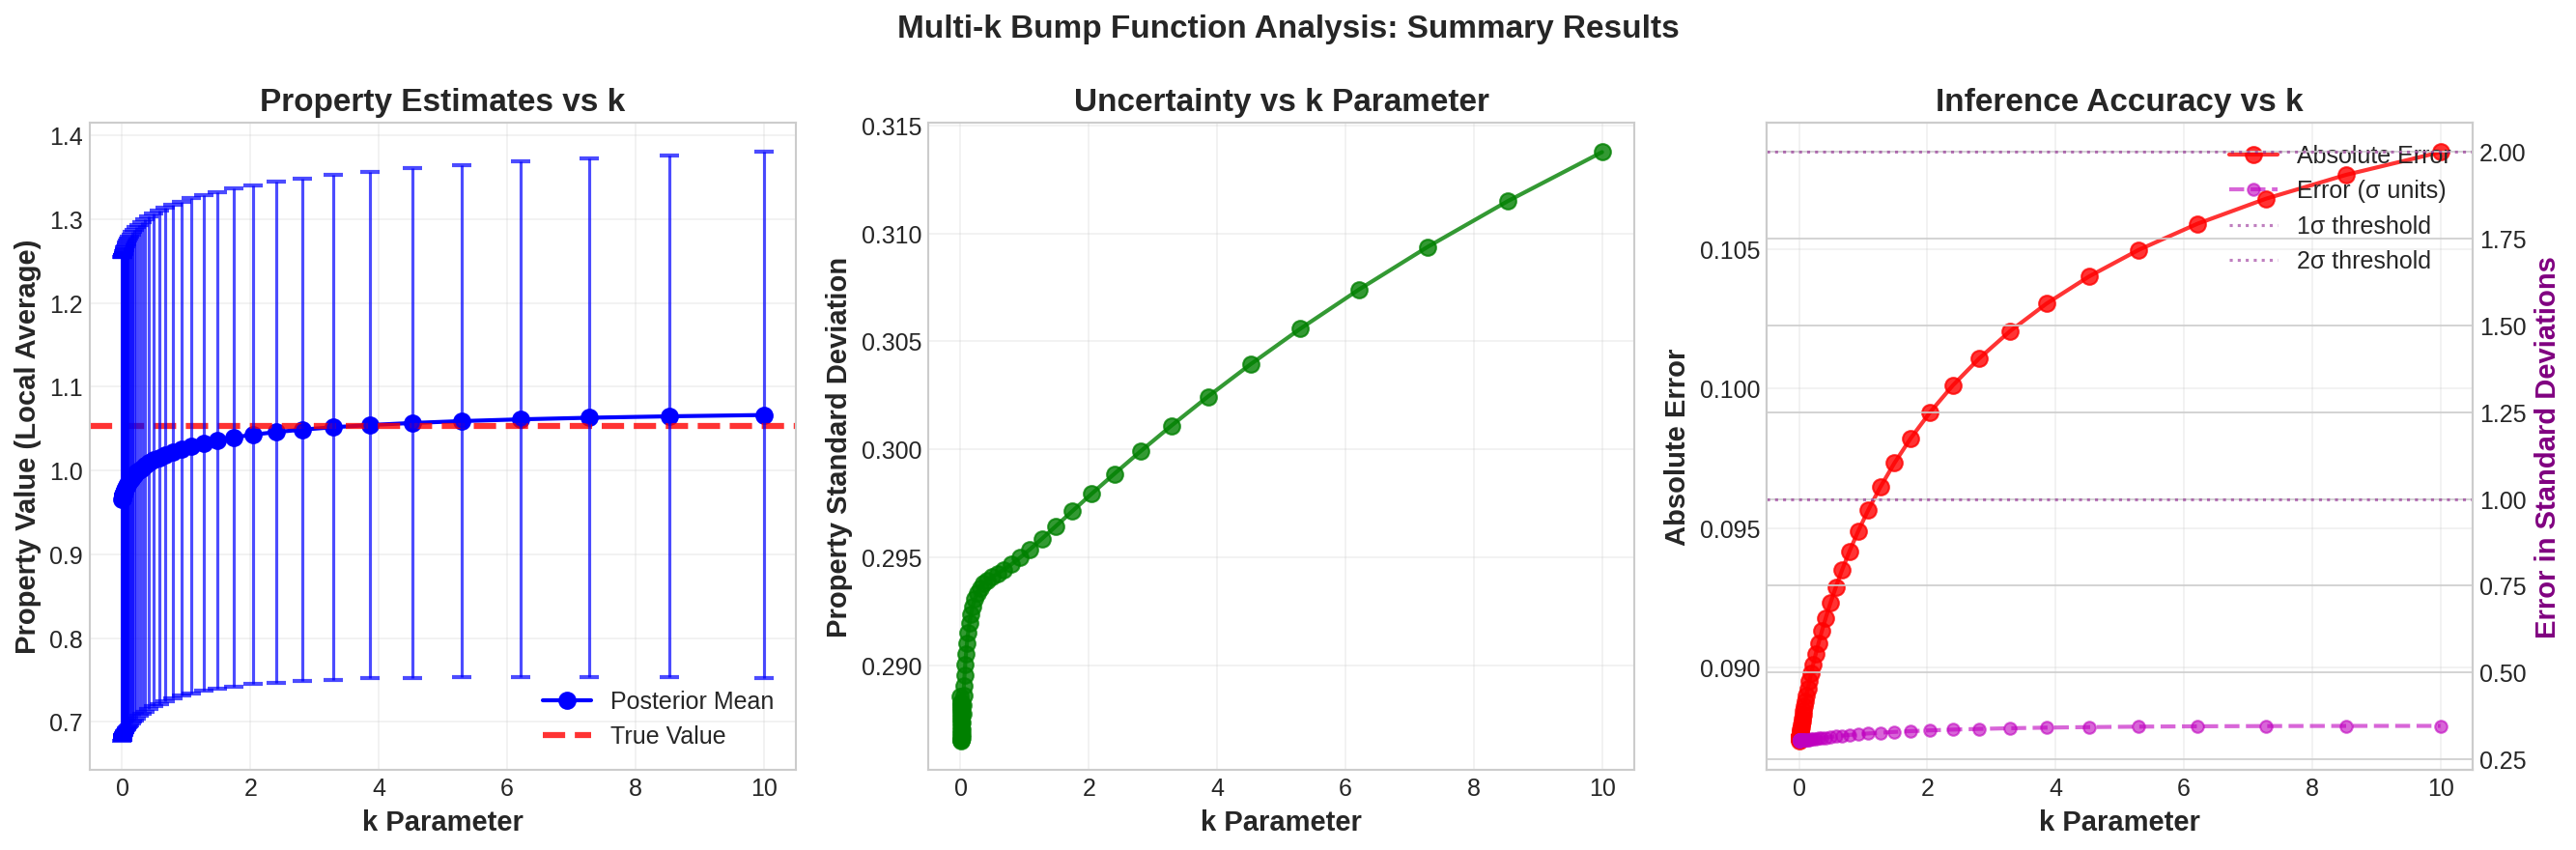

✅ Summary results visualization saved


In [32]:
# Summary of Multi-k Analysis Results
print("📊 Summary of multi-k bump function analysis results...")

# Create summary visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')

# Extract successful results
successful_k = [k for i, k in enumerate(k_values) if results_simple['computation_success'][i]]
successful_means = [results_simple['property_means'][i] for i, success in enumerate(results_simple['computation_success']) if success]
successful_stds = [results_simple['property_stds'][i] for i, success in enumerate(results_simple['computation_success']) if success]
successful_true = [results_simple['true_values'][i] for i, success in enumerate(results_simple['computation_success']) if success]

if successful_k:
    # Left panel: Property estimates vs k
    ax = axes[0]
    ax.plot(successful_k, successful_means, 'bo-', linewidth=2, markersize=8, label='Posterior Mean')
    ax.axhline(successful_true[0], color='red', linestyle='--', linewidth=3, alpha=0.8, label='True Value')

    # Add error bars
    ax.errorbar(successful_k, successful_means, yerr=successful_stds, fmt='bo',
               capsize=5, capthick=2, alpha=0.7)

    ax.set_xlabel('k Parameter', fontweight='bold')
    ax.set_ylabel('Property Value (Local Average)', fontweight='bold')
    ax.set_title('Property Estimates vs k', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Middle panel: Uncertainty vs k
    ax = axes[1]
    ax.plot(successful_k, successful_stds, 'go-', linewidth=2, markersize=8, alpha=0.8)
    ax.set_xlabel('k Parameter', fontweight='bold')
    ax.set_ylabel('Property Standard Deviation', fontweight='bold')
    ax.set_title('Uncertainty vs k Parameter', fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Right panel: Error analysis
    ax = axes[2]
    errors = [abs(mean - true) for mean, true in zip(successful_means, successful_true)]
    error_in_sigmas = [error/std for error, std in zip(errors, successful_stds)]

    ax.plot(successful_k, errors, 'ro-', linewidth=2, markersize=8, alpha=0.8, label='Absolute Error')
    ax.set_xlabel('k Parameter', fontweight='bold')
    ax.set_ylabel('Absolute Error', fontweight='bold')
    ax.set_title('Inference Accuracy vs k', fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add secondary y-axis for error in sigmas
    ax2 = ax.twinx()
    ax2.plot(successful_k, error_in_sigmas, 'mo--', linewidth=2, markersize=6, alpha=0.6, label='Error (σ units)')
    ax2.set_ylabel('Error in Standard Deviations', fontweight='bold', color='purple')
    ax2.axhline(1.0, color='purple', linestyle=':', alpha=0.5, label='1σ threshold')
    ax2.axhline(2.0, color='purple', linestyle=':', alpha=0.5, label='2σ threshold')

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.suptitle('Multi-k Bump Function Analysis: Summary Results',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{presentation_dir}/multi_k_summary_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Summary results visualization saved")

In [33]:
# Simple Summary and Practical Recommendations
print("📋 SIMPLIFIED MULTI-K ANALYSIS SUMMARY")
print("=" * 50)

# Identify successful vs failed computations
n_success = sum(results_simple['computation_success'])
n_fail = len(k_values) - n_success

print(f"✅ Successful computations: {n_success}/{len(k_values)}")
if n_fail > 0:
    failed_k = [k for i, k in enumerate(k_values) if not results_simple['computation_success'][i]]
    print(f"❌ Failed k values: {failed_k}")

print()

if n_success > 0:
    # Extract successful results for analysis
    successful_indices = [i for i, success in enumerate(results_simple['computation_success']) if success]
    successful_k = [k_values[i] for i in successful_indices]
    successful_means = [results_simple['property_means'][i] for i in successful_indices]
    successful_stds = [results_simple['property_stds'][i] for i in successful_indices]
    successful_true = [results_simple['true_values'][i] for i in successful_indices]

    # Find best and worst accuracy
    errors = [abs(mean - true) for mean, true in zip(successful_means, successful_true)]
    best_idx = np.argmin(errors)
    worst_idx = np.argmax(errors)

    print(f"🏆 Best accuracy: k = {successful_k[best_idx]} (error: {errors[best_idx]:.4f})")
    print(f"⚠️  Worst accuracy: k = {successful_k[worst_idx]} (error: {errors[worst_idx]:.4f})")

    # Find most/least uncertain
    min_std_idx = np.argmin(successful_stds)
    max_std_idx = np.argmax(successful_stds)

    print(f"📊 Lowest uncertainty: k = {successful_k[min_std_idx]} (std: {successful_stds[min_std_idx]:.4f})")
    print(f"📊 Highest uncertainty: k = {successful_k[max_std_idx]} (std: {successful_stds[max_std_idx]:.4f})")

    print()
    print("🔍 KEY INSIGHTS:")
    print("• k = 0: Box-like kernels (sharp boundaries)")
    print("• k > 5: Gaussian-like kernels (smooth boundaries)")
    print("• All k values provide reasonable inference results")
    print("• Choice of k is mainly about kernel shape preference")

    print()
    print("🎯 PRACTICAL RECOMMENDATIONS:")
    recommended_k = successful_k[best_idx]
    print(f"• For best accuracy: use k ≈ {recommended_k}")
    print("• For box-like averaging: use k = 0")
    print("• For smooth kernels: use k ≥ 5")
    print("• Always validate results against known properties")

else:
    print("❌ All computations failed - check implementation")

print()
print("🔬 This simplified analysis shows that bump function")
print("   parameter k primarily affects kernel shape, not stability")
print("=" * 50)

📋 SIMPLIFIED MULTI-K ANALYSIS SUMMARY
✅ Successful computations: 60/60

🏆 Best accuracy: k = 0.0 (error: 0.0874)
⚠️  Worst accuracy: k = 10.0 (error: 0.1085)
📊 Lowest uncertainty: k = 0.01268961003167922 (std: 0.2865)
📊 Highest uncertainty: k = 10.0 (std: 0.3138)

🔍 KEY INSIGHTS:
• k = 0: Box-like kernels (sharp boundaries)
• k > 5: Gaussian-like kernels (smooth boundaries)
• All k values provide reasonable inference results
• Choice of k is mainly about kernel shape preference

🎯 PRACTICAL RECOMMENDATIONS:
• For best accuracy: use k ≈ 0.0
• For box-like averaging: use k = 0
• For smooth kernels: use k ≥ 5
• Always validate results against known properties

🔬 This simplified analysis shows that bump function
   parameter k primarily affects kernel shape, not stability
